In [15]:

import requests
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Input, Bidirectional, LSTM, Attention, BatchNormalization, AlphaDropout, Dense
from keras.losses import mean_squared_error
from keras.metrics import RootMeanSquaredError
from keras.initializers import RandomUniform
from keras.optimizers import Adam
from keras.activations import selu

In [16]:
def get_forex_exchange(symbol):
    params = {
        'function': 'CURRENCY_EXCHANGE_RATE',
        'from_currency': symbol[:3],
        'to_currency': symbol[3:],
        'apikey': API_KEY
    }

    try:
        response = requests.get(BASE_URL, params=params)
        data = response.json()

        forex_exchange = pd.DataFrame({
            'exchange_rate': float(data['Realtime Currency Exchange Rate']['5. Exchange Rate']),
            'bid_price': float(data['Realtime Currency Exchange Rate']['8. Bid Price']),
            'ask_price': float(data['Realtime Currency Exchange Rate']['9. Ask Price'])
        }, index=[pd.to_datetime(data['Realtime Currency Exchange Rate']['6. Last Refreshed'])])
        forex_exchange.index.name = 'time'

        return forex_exchange
    except Exception as e:
        print(f'Error fetching forex exchange details: {e}')
        return pd.DataFrame()

In [17]:
def create_lstm_model(n_steps, n_features):
    input_layer = Input(shape=(n_steps, n_features))
    # x= Dense()
    x = Bidirectional(LSTM(units=128, return_sequences=True, use_bias=True, activation="linear",kernel_initializer=RandomUniform(minval=-10, maxval=10)))(input_layer)
    x = Attention()([x, x])
    x = BatchNormalization()(x)

    # for i in range():
    x = Bidirectional(LSTM(units=256, use_bias=True, return_sequences=True, dropout=0.5, activation="linear",kernel_initializer=RandomUniform(minval=-10, maxval=10)))(x)
    x = Attention()([x, x])
    x = BatchNormalization()(x)
    # x = AlphaDropout(0.1)(x)
    x = Bidirectional(LSTM(units=512, use_bias=True, return_sequences=True, dropout=0.25, activation="linear",kernel_initializer=RandomUniform(minval=-10, maxval=10)))(x)
    x = Attention()([x, x])
    x = BatchNormalization()(x)
    x = Bidirectional(LSTM(units=512, use_bias=True, return_sequences=True, dropout=0.75, activation="linear",kernel_initializer=RandomUniform(minval=-10, maxval=10)))(x)
    x = Attention()([x, x])
    x = BatchNormalization()(x)
    # x = AlphaDropout(0.1)(x)
    x = Bidirectional(LSTM(units=256, use_bias=True, return_sequences=True, dropout=0.5, activation="linear",kernel_initializer=RandomUniform(minval=-10, maxval=10)))(x)
    x = Attention()([x, x])
    x = BatchNormalization()(x)
    # x = AlphaDropout(0.1)(x)

    x = Bidirectional(LSTM(units=128, return_sequences=False, use_bias=True, activation="linear",kernel_initializer=RandomUniform(minval=-10, maxval=10)))(x)
    x = Attention()([x, x])
    x = BatchNormalization()(x)
    # x = AlphaDropout(0.1)(x)

    x = Dense(units=1, activation='linear')(x)

    model = Model(inputs=input_layer, outputs=x)
    optimizer = Adam(0.001,clipnorm=0.01)
    model.compile(optimizer=optimizer, loss=mean_squared_error, metrics=['accuracy',RootMeanSquaredError()])
    model.summary()
    return model

In [18]:
def splitsequence(data, n_steps, n_features):

    # Declare X and y as empty list
    X = []
    y = []
    for i in np.arange(n_steps, len(data)):
        X.append(data.iloc[i-n_steps:i, :].values)
        y.append(data['exchange_rate'][i])
    X, y = np.array(X), np.array(y)
    X = X.reshape(X.shape[0], n_steps, n_features)
    return X, y


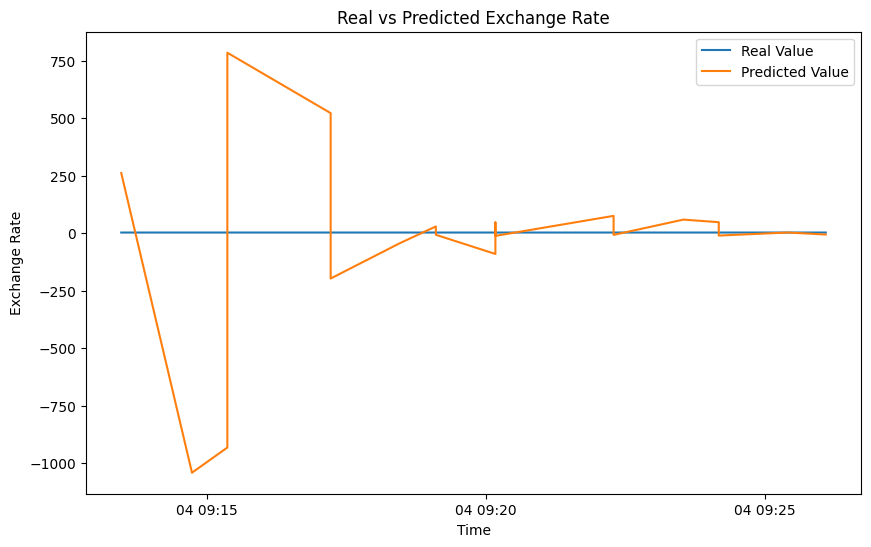

In [29]:
plot_(predictions_df)

In [30]:

def plot_(data):
  plt.figure(figsize=(10, 6))
  plt.plot(data['real_value'].tail(20), label='Real Value')
  plt.plot(data['predicted_value'].tail(20), label='Predicted Value')
  plt.xlabel('Time')
  plt.ylabel('Exchange Rate')
  plt.title('Real vs Predicted Exchange Rate')
  plt.legend()
  plt.show()
  # plt.figure(figsize=(10, 6))
  # # plt.plot(data.index, data['real_value'], label='Real Value')
  # plt.plot(data.index, data['predicted_value'], label='Predicted Value')
  # plt.xlabel('Time')
  # plt.ylabel('Exchange Rate')
  # plt.title('Real vs Predicted Exchange Rate')
  # plt.legend()
  # plt.show()

In [20]:
df

,exchange_rate,bid_price,ask_price
2023-07-04 08:46:39,2.535664,2.535664,2.535665
2023-07-04 08:48:13,2.535167,2.535167,2.535167
2023-07-04 08:49:14,2.532956,2.532955,2.532956


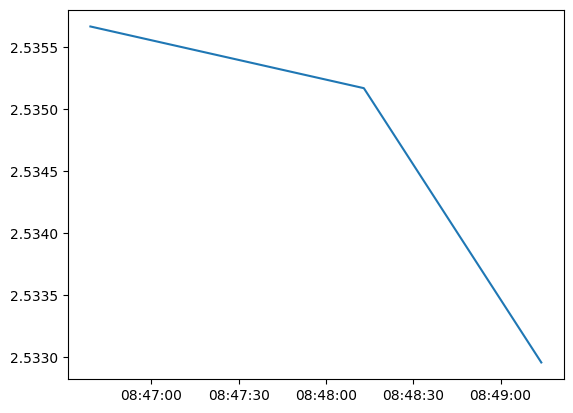

In [21]:
plt.plot(df['exchange_rate'].tail(10))

In [22]:
BASE_URL = 'https://www.alphavantage.co/query?'
API_KEY = 'K37TOUDE2WB29LQJ'
SYMBOL = 'BTCINR'  # Example forex exchange symbol
BATCH_SIZE =16
epoch=2
# NUM_FEATURES = 3
n_features=3
n_steps=5
TIME_DELAY = 35  # Time delay in seconds


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 5, 3)]       0           []                               
                                                                                                  
 bidirectional_12 (Bidirectiona  (None, 5, 256)      135168      ['input_3[0][0]']                
 l)                                                                                               
                                                                                                  
 attention_12 (Attention)       (None, 5, 256)       0           ['bidirectional_12[0][0]',       
                                                                  'bidirectional_12[0][0]']       
                                                                                            

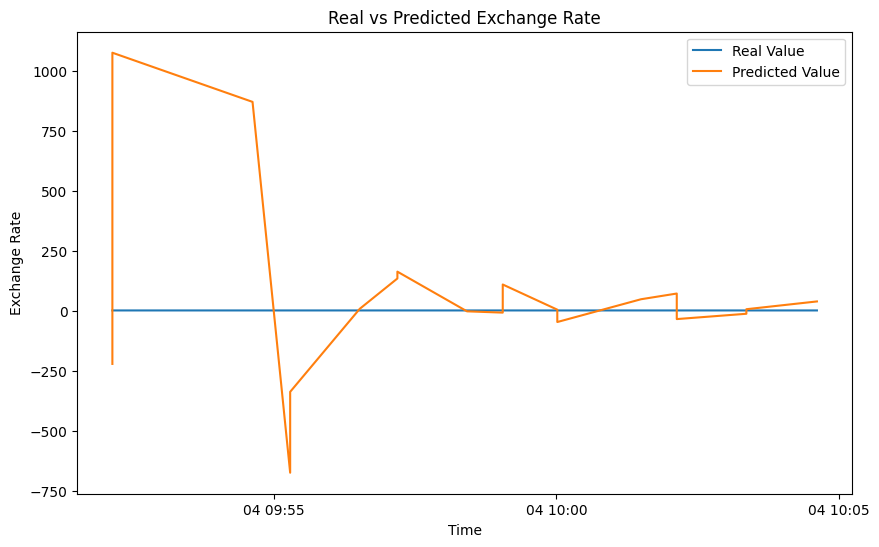

1/1 [==============================] - 0s 72ms/step
prediction [[-8.64978]]
                     real_value  predicted_value  absolute Error
2023-07-04 09:48:02    2.537859    -50215.437500    50217.976562
2023-07-04 09:49:01    2.538690     -7169.165039     7171.703613
2023-07-04 09:49:01    2.538690     17789.552734    17787.013672
2023-07-04 09:50:01    2.538944    -11331.566406    11334.105469
2023-07-04 09:50:01    2.538944     -2951.120117     2953.659180
2023-07-04 09:51:31    2.539509      4272.868164     4270.328613
2023-07-04 09:52:08    2.539836     -1133.643677     1136.183472
2023-07-04 09:52:08    2.539836      -219.972626      222.512466
2023-07-04 09:52:08    2.539836       363.229095      360.689270
2023-07-04 09:52:08    2.539836      1074.836792     1072.296997
2023-07-04 09:54:37    2.540328       870.270508      867.730164
2023-07-04 09:55:17    2.539722      -672.652832      675.192566
2023-07-04 09:55:17    2.539722      -336.140900      338.680634
2023-07-04 09:

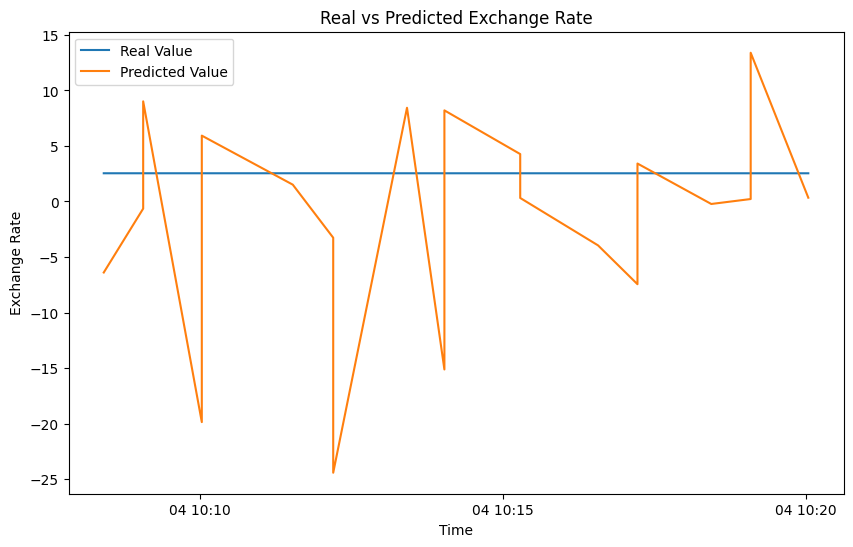

1/1 [==============================] - 0s 53ms/step
prediction [[4.865362]]
                     real_value  predicted_value  absolute Error
2023-07-04 09:48:02    2.537859    -50215.437500    50217.976562
2023-07-04 09:49:01    2.538690     -7169.165039     7171.703613
2023-07-04 09:49:01    2.538690     17789.552734    17787.013672
2023-07-04 09:50:01    2.538944    -11331.566406    11334.105469
2023-07-04 09:50:01    2.538944     -2951.120117     2953.659180
2023-07-04 09:51:31    2.539509      4272.868164     4270.328613
2023-07-04 09:52:08    2.539836     -1133.643677     1136.183472
2023-07-04 09:52:08    2.539836      -219.972626      222.512466
2023-07-04 09:52:08    2.539836       363.229095      360.689270
2023-07-04 09:52:08    2.539836      1074.836792     1072.296997
2023-07-04 09:54:37    2.540328       870.270508      867.730164
2023-07-04 09:55:17    2.539722      -672.652832      675.192566
2023-07-04 09:55:17    2.539722      -336.140900      338.680634
2023-07-04 09:

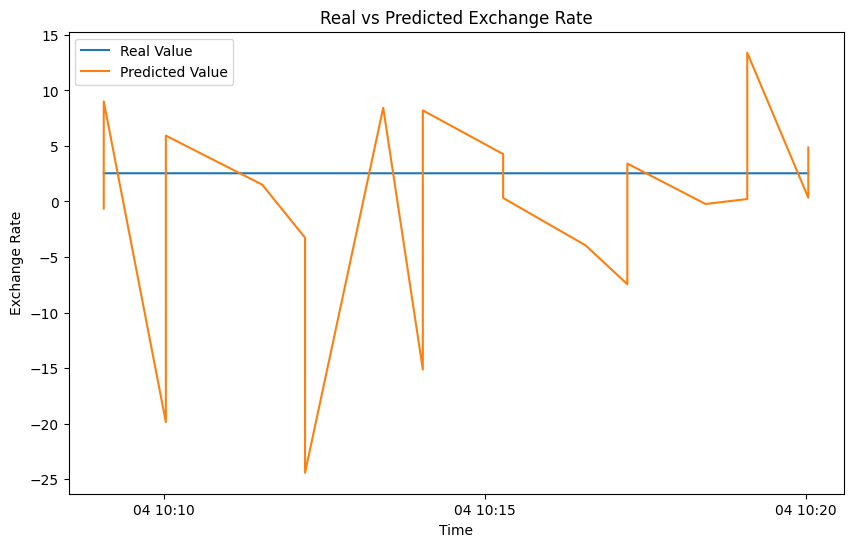

KeyboardInterrupt: ignored

In [31]:
# # Create an empty DataFrame
# df = pd.DataFrame(columns=['exchange_rate', 'bid_price', 'ask_price'])

# model = create_lstm_model(n_steps,n_features)

# predictions_df = pd.DataFrame(columns=['real_value', 'predicted_value'])

# while True:
#     forex_exchange = get_forex_exchange(SYMBOL)
#     forex_exchange/=1e+6
#     if not forex_exchange.empty:
#         df = pd.concat([df, forex_exchange]).drop_duplicates()
#         num_samples = df.shape[0]
#     if num_samples > BATCH_SIZE:
#         start_index = num_samples - BATCH_SIZE -1
#         end_index = num_samples

#         features,labels= splitsequence(df.iloc[start_index:,:],n_steps,n_features)

#         for _ in range(epoch):
#           model.train_on_batch(features, labels)

#         x_=features[-1].reshape(1,n_steps,n_features)
#         predictions = model.predict(x_)

#         print("prediction",predictions)

#         new_predictions = pd.DataFrame({
#             'real_value': df['exchange_rate'][end_index-1],
#             'predicted_value': predictions[0],
#             'absolute Error': abs(df['exchange_rate'][end_index-1]-predictions[0])
#         },index=[pd.to_datetime(df.index[end_index-1])])

#         predictions_df = pd.concat([predictions_df, new_predictions],ignore_index=False)
#         print(predictions_df)
#         if num_samples % BATCH_SIZE == 0:
#             plot_(predictions_df)


#         time.sleep(TIME_DELAY)
#     else:
#         time.sleep(30)

# #

In [51]:
# Create an empty DataFrame
df = pd.DataFrame(columns=['exchange_rate', 'bid_price', 'ask_price'])

model = create_lstm_model(n_steps,n_features)

predictions_df = pd.DataFrame(columns=['real_value', 'predicted_value','absolute Error'])

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 5, 3)]       0           []                               
                                                                                                  
 bidirectional_36 (Bidirectiona  (None, 5, 256)      135168      ['input_7[0][0]']                
 l)                                                                                               
                                                                                                  
 attention_36 (Attention)       (None, 5, 256)       0           ['bidirectional_36[0][0]',       
                                                                  'bidirectional_36[0][0]']       
                                                                                            

1/1 [==============================] - 0s 55ms/step
prediction [[66.65635]]
   real_value predicted_value  absolute Error
0    2.546317     [-441477.5]   441480.031250
1    2.546317     [7243.0967]     7240.550293
2    2.545834    [-19825.227]    19827.771484
3    2.547772     [-3798.946]     3801.493896
4    2.547772     [-528.8472]      531.395020
5    2.547772      [898.2568]      895.708984
6    2.548628     [-901.3606]      903.909241
7    2.548628     [5.0158896]        2.467261
8    2.546562    [-16.238266]       18.784828
9    2.546562     [224.07607]      221.529495
10   2.545871     [444.37958]      441.833710
11   2.545094     [220.54985]      218.004761
12   2.545094     [66.666794]       64.121704
13    2.54594   [-10.8755045]       13.421444
14   2.545197     [147.49713]      144.951935
15   2.545197    [-29.062845]       31.608042
16        NaN      [66.65635]             NaN


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 51ms/step
prediction [[19.024704]]
   real_value predicted_value  absolute Error
0    2.546317     [-441477.5]   441480.031250
1    2.546317     [7243.0967]     7240.550293
2    2.545834    [-19825.227]    19827.771484
3    2.547772     [-3798.946]     3801.493896
4    2.547772     [-528.8472]      531.395020
5    2.547772      [898.2568]      895.708984
6    2.548628     [-901.3606]      903.909241
7    2.548628     [5.0158896]        2.467261
8    2.546562    [-16.238266]       18.784828
9    2.546562     [224.07607]      221.529495
10   2.545871     [444.37958]      441.833710
11   2.545094     [220.54985]      218.004761
12   2.545094     [66.666794]       64.121704
13    2.54594   [-10.8755045]       13.421444
14   2.545197     [147.49713]      144.951935
15   2.545197    [-29.062845]       31.608042
16   2.545197      [66.65635]       64.111153
17        NaN     [19.024704]             NaN


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 50ms/step
prediction [[42.29437]]
   real_value predicted_value  absolute Error
0    2.546317     [-441477.5]   441480.031250
1    2.546317     [7243.0967]     7240.550293
2    2.545834    [-19825.227]    19827.771484
3    2.547772     [-3798.946]     3801.493896
4    2.547772     [-528.8472]      531.395020
5    2.547772      [898.2568]      895.708984
6    2.548628     [-901.3606]      903.909241
7    2.548628     [5.0158896]        2.467261
8    2.546562    [-16.238266]       18.784828
9    2.546562     [224.07607]      221.529495
10   2.545871     [444.37958]      441.833710
11   2.545094     [220.54985]      218.004761
12   2.545094     [66.666794]       64.121704
13    2.54594   [-10.8755045]       13.421444
14   2.545197     [147.49713]      144.951935
15   2.545197    [-29.062845]       31.608042
16   2.545197      [66.65635]       64.111153
17   2.545016     [19.024704]       16.479689
18        NaN      [42.29437]             NaN


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 62ms/step
prediction [[21.810122]]
   real_value predicted_value  absolute Error
0    2.546317     [-441477.5]   441480.031250
1    2.546317     [7243.0967]     7240.550293
2    2.545834    [-19825.227]    19827.771484
3    2.547772     [-3798.946]     3801.493896
4    2.547772     [-528.8472]      531.395020
5    2.547772      [898.2568]      895.708984
6    2.548628     [-901.3606]      903.909241
7    2.548628     [5.0158896]        2.467261
8    2.546562    [-16.238266]       18.784828
9    2.546562     [224.07607]      221.529495
10   2.545871     [444.37958]      441.833710
11   2.545094     [220.54985]      218.004761
12   2.545094     [66.666794]       64.121704
13    2.54594   [-10.8755045]       13.421444
14   2.545197     [147.49713]      144.951935
15   2.545197    [-29.062845]       31.608042
16   2.545197      [66.65635]       64.111153
17   2.545016     [19.024704]       16.479689
18   2.545705      [42.29437]       39.748665
19 

<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 51ms/step
prediction [[-54.361336]]
   real_value predicted_value  absolute Error
0    2.546317     [-441477.5]   441480.031250
1    2.546317     [7243.0967]     7240.550293
2    2.545834    [-19825.227]    19827.771484
3    2.547772     [-3798.946]     3801.493896
4    2.547772     [-528.8472]      531.395020
5    2.547772      [898.2568]      895.708984
6    2.548628     [-901.3606]      903.909241
7    2.548628     [5.0158896]        2.467261
8    2.546562    [-16.238266]       18.784828
9    2.546562     [224.07607]      221.529495
10   2.545871     [444.37958]      441.833710
11   2.545094     [220.54985]      218.004761
12   2.545094     [66.666794]       64.121704
13    2.54594   [-10.8755045]       13.421444
14   2.545197     [147.49713]      144.951935
15   2.545197    [-29.062845]       31.608042
16   2.545197      [66.65635]       64.111153
17   2.545016     [19.024704]       16.479689
18   2.545705      [42.29437]       39.748665
19

<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 99ms/step
prediction [[34.963596]]
   real_value predicted_value  absolute Error
0    2.546317     [-441477.5]   441480.031250
1    2.546317     [7243.0967]     7240.550293
2    2.545834    [-19825.227]    19827.771484
3    2.547772     [-3798.946]     3801.493896
4    2.547772     [-528.8472]      531.395020
5    2.547772      [898.2568]      895.708984
6    2.548628     [-901.3606]      903.909241
7    2.548628     [5.0158896]        2.467261
8    2.546562    [-16.238266]       18.784828
9    2.546562     [224.07607]      221.529495
10   2.545871     [444.37958]      441.833710
11   2.545094     [220.54985]      218.004761
12   2.545094     [66.666794]       64.121704
13    2.54594   [-10.8755045]       13.421444
14   2.545197     [147.49713]      144.951935
15   2.545197    [-29.062845]       31.608042
16   2.545197      [66.65635]       64.111153
17   2.545016     [19.024704]       16.479689
18   2.545705      [42.29437]       39.748665
19 

<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 79ms/step
prediction [[-43.450268]]
   real_value predicted_value  absolute Error
0    2.546317     [-441477.5]   441480.031250
1    2.546317     [7243.0967]     7240.550293
2    2.545834    [-19825.227]    19827.771484
3    2.547772     [-3798.946]     3801.493896
4    2.547772     [-528.8472]      531.395020
5    2.547772      [898.2568]      895.708984
6    2.548628     [-901.3606]      903.909241
7    2.548628     [5.0158896]        2.467261
8    2.546562    [-16.238266]       18.784828
9    2.546562     [224.07607]      221.529495
10   2.545871     [444.37958]      441.833710
11   2.545094     [220.54985]      218.004761
12   2.545094     [66.666794]       64.121704
13    2.54594   [-10.8755045]       13.421444
14   2.545197     [147.49713]      144.951935
15   2.545197    [-29.062845]       31.608042
16   2.545197      [66.65635]       64.111153
17   2.545016     [19.024704]       16.479689
18   2.545705      [42.29437]       39.748665
19

<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 53ms/step
prediction [[18.968029]]
   real_value predicted_value  absolute Error
0    2.546317     [-441477.5]   441480.031250
1    2.546317     [7243.0967]     7240.550293
2    2.545834    [-19825.227]    19827.771484
3    2.547772     [-3798.946]     3801.493896
4    2.547772     [-528.8472]      531.395020
5    2.547772      [898.2568]      895.708984
6    2.548628     [-901.3606]      903.909241
7    2.548628     [5.0158896]        2.467261
8    2.546562    [-16.238266]       18.784828
9    2.546562     [224.07607]      221.529495
10   2.545871     [444.37958]      441.833710
11   2.545094     [220.54985]      218.004761
12   2.545094     [66.666794]       64.121704
13    2.54594   [-10.8755045]       13.421444
14   2.545197     [147.49713]      144.951935
15   2.545197    [-29.062845]       31.608042
16   2.545197      [66.65635]       64.111153
17   2.545016     [19.024704]       16.479689
18   2.545705      [42.29437]       39.748665
19 

<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 51ms/step
prediction [[19.914776]]
   real_value predicted_value  absolute Error
0    2.546317     [-441477.5]   441480.031250
1    2.546317     [7243.0967]     7240.550293
2    2.545834    [-19825.227]    19827.771484
3    2.547772     [-3798.946]     3801.493896
4    2.547772     [-528.8472]      531.395020
5    2.547772      [898.2568]      895.708984
6    2.548628     [-901.3606]      903.909241
7    2.548628     [5.0158896]        2.467261
8    2.546562    [-16.238266]       18.784828
9    2.546562     [224.07607]      221.529495
10   2.545871     [444.37958]      441.833710
11   2.545094     [220.54985]      218.004761
12   2.545094     [66.666794]       64.121704
13    2.54594   [-10.8755045]       13.421444
14   2.545197     [147.49713]      144.951935
15   2.545197    [-29.062845]       31.608042
16   2.545197      [66.65635]       64.111153
17   2.545016     [19.024704]       16.479689
18   2.545705      [42.29437]       39.748665
19 

<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 54ms/step
prediction [[18.04095]]
   real_value predicted_value  absolute Error
0    2.546317     [-441477.5]   441480.031250
1    2.546317     [7243.0967]     7240.550293
2    2.545834    [-19825.227]    19827.771484
3    2.547772     [-3798.946]     3801.493896
4    2.547772     [-528.8472]      531.395020
5    2.547772      [898.2568]      895.708984
6    2.548628     [-901.3606]      903.909241
7    2.548628     [5.0158896]        2.467261
8    2.546562    [-16.238266]       18.784828
9    2.546562     [224.07607]      221.529495
10   2.545871     [444.37958]      441.833710
11   2.545094     [220.54985]      218.004761
12   2.545094     [66.666794]       64.121704
13    2.54594   [-10.8755045]       13.421444
14   2.545197     [147.49713]      144.951935
15   2.545197    [-29.062845]       31.608042
16   2.545197      [66.65635]       64.111153
17   2.545016     [19.024704]       16.479689
18   2.545705      [42.29437]       39.748665
19  

<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


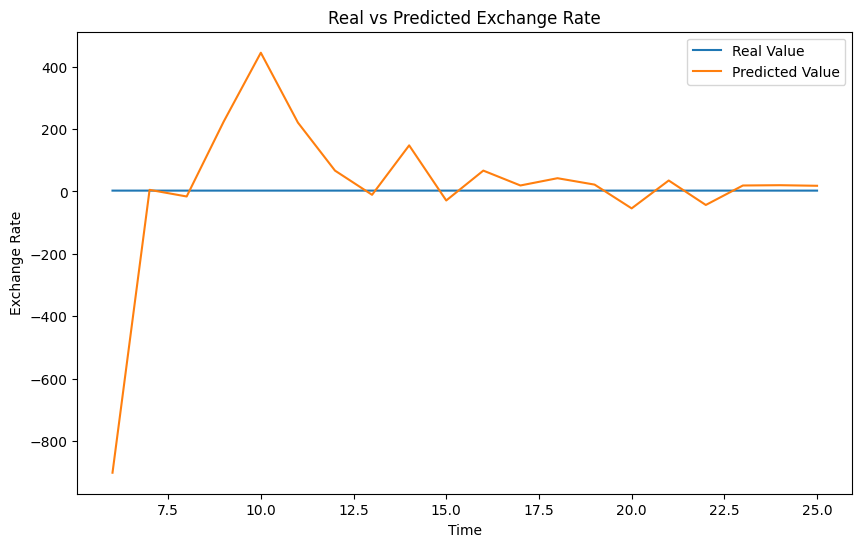

1/1 [==============================] - 0s 55ms/step
prediction [[17.053894]]
   real_value predicted_value  absolute Error
0    2.546317     [-441477.5]   441480.031250
1    2.546317     [7243.0967]     7240.550293
2    2.545834    [-19825.227]    19827.771484
3    2.547772     [-3798.946]     3801.493896
4    2.547772     [-528.8472]      531.395020
5    2.547772      [898.2568]      895.708984
6    2.548628     [-901.3606]      903.909241
7    2.548628     [5.0158896]        2.467261
8    2.546562    [-16.238266]       18.784828
9    2.546562     [224.07607]      221.529495
10   2.545871     [444.37958]      441.833710
11   2.545094     [220.54985]      218.004761
12   2.545094     [66.666794]       64.121704
13    2.54594   [-10.8755045]       13.421444
14   2.545197     [147.49713]      144.951935
15   2.545197    [-29.062845]       31.608042
16   2.545197      [66.65635]       64.111153
17   2.545016     [19.024704]       16.479689
18   2.545705      [42.29437]       39.748665
19 

<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 52ms/step
prediction [[2.936264]]
   real_value predicted_value  absolute Error
0    2.546317     [-441477.5]   441480.031250
1    2.546317     [7243.0967]     7240.550293
2    2.545834    [-19825.227]    19827.771484
3    2.547772     [-3798.946]     3801.493896
4    2.547772     [-528.8472]      531.395020
5    2.547772      [898.2568]      895.708984
6    2.548628     [-901.3606]      903.909241
7    2.548628     [5.0158896]        2.467261
8    2.546562    [-16.238266]       18.784828
9    2.546562     [224.07607]      221.529495
10   2.545871     [444.37958]      441.833710
11   2.545094     [220.54985]      218.004761
12   2.545094     [66.666794]       64.121704
13    2.54594   [-10.8755045]       13.421444
14   2.545197     [147.49713]      144.951935
15   2.545197    [-29.062845]       31.608042
16   2.545197      [66.65635]       64.111153
17   2.545016     [19.024704]       16.479689
18   2.545705      [42.29437]       39.748665
19  

<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 53ms/step
prediction [[20.271019]]
   real_value predicted_value  absolute Error
0    2.546317     [-441477.5]   441480.031250
1    2.546317     [7243.0967]     7240.550293
2    2.545834    [-19825.227]    19827.771484
3    2.547772     [-3798.946]     3801.493896
4    2.547772     [-528.8472]      531.395020
5    2.547772      [898.2568]      895.708984
6    2.548628     [-901.3606]      903.909241
7    2.548628     [5.0158896]        2.467261
8    2.546562    [-16.238266]       18.784828
9    2.546562     [224.07607]      221.529495
10   2.545871     [444.37958]      441.833710
11   2.545094     [220.54985]      218.004761
12   2.545094     [66.666794]       64.121704
13    2.54594   [-10.8755045]       13.421444
14   2.545197     [147.49713]      144.951935
15   2.545197    [-29.062845]       31.608042
16   2.545197      [66.65635]       64.111153
17   2.545016     [19.024704]       16.479689
18   2.545705      [42.29437]       39.748665
19 

<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 84ms/step
prediction [[-3.6525955]]
   real_value predicted_value  absolute Error
0    2.546317     [-441477.5]   441480.031250
1    2.546317     [7243.0967]     7240.550293
2    2.545834    [-19825.227]    19827.771484
3    2.547772     [-3798.946]     3801.493896
4    2.547772     [-528.8472]      531.395020
5    2.547772      [898.2568]      895.708984
6    2.548628     [-901.3606]      903.909241
7    2.548628     [5.0158896]        2.467261
8    2.546562    [-16.238266]       18.784828
9    2.546562     [224.07607]      221.529495
10   2.545871     [444.37958]      441.833710
11   2.545094     [220.54985]      218.004761
12   2.545094     [66.666794]       64.121704
13    2.54594   [-10.8755045]       13.421444
14   2.545197     [147.49713]      144.951935
15   2.545197    [-29.062845]       31.608042
16   2.545197      [66.65635]       64.111153
17   2.545016     [19.024704]       16.479689
18   2.545705      [42.29437]       39.748665
19

<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 72ms/step
prediction [[-9.4417]]
   real_value predicted_value  absolute Error
0    2.546317     [-441477.5]   441480.031250
1    2.546317     [7243.0967]     7240.550293
2    2.545834    [-19825.227]    19827.771484
3    2.547772     [-3798.946]     3801.493896
4    2.547772     [-528.8472]      531.395020
5    2.547772      [898.2568]      895.708984
6    2.548628     [-901.3606]      903.909241
7    2.548628     [5.0158896]        2.467261
8    2.546562    [-16.238266]       18.784828
9    2.546562     [224.07607]      221.529495
10   2.545871     [444.37958]      441.833710
11   2.545094     [220.54985]      218.004761
12   2.545094     [66.666794]       64.121704
13    2.54594   [-10.8755045]       13.421444
14   2.545197     [147.49713]      144.951935
15   2.545197    [-29.062845]       31.608042
16   2.545197      [66.65635]       64.111153
17   2.545016     [19.024704]       16.479689
18   2.545705      [42.29437]       39.748665
19   

<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 52ms/step
prediction [[3.750532]]
   real_value predicted_value  absolute Error
0    2.546317     [-441477.5]   441480.031250
1    2.546317     [7243.0967]     7240.550293
2    2.545834    [-19825.227]    19827.771484
3    2.547772     [-3798.946]     3801.493896
4    2.547772     [-528.8472]      531.395020
5    2.547772      [898.2568]      895.708984
6    2.548628     [-901.3606]      903.909241
7    2.548628     [5.0158896]        2.467261
8    2.546562    [-16.238266]       18.784828
9    2.546562     [224.07607]      221.529495
10   2.545871     [444.37958]      441.833710
11   2.545094     [220.54985]      218.004761
12   2.545094     [66.666794]       64.121704
13    2.54594   [-10.8755045]       13.421444
14   2.545197     [147.49713]      144.951935
15   2.545197    [-29.062845]       31.608042
16   2.545197      [66.65635]       64.111153
17   2.545016     [19.024704]       16.479689
18   2.545705      [42.29437]       39.748665
19  

<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 50ms/step
prediction [[7.4629636]]
   real_value predicted_value  absolute Error
0    2.546317     [-441477.5]   441480.031250
1    2.546317     [7243.0967]     7240.550293
2    2.545834    [-19825.227]    19827.771484
3    2.547772     [-3798.946]     3801.493896
4    2.547772     [-528.8472]      531.395020
5    2.547772      [898.2568]      895.708984
6    2.548628     [-901.3606]      903.909241
7    2.548628     [5.0158896]        2.467261
8    2.546562    [-16.238266]       18.784828
9    2.546562     [224.07607]      221.529495
10   2.545871     [444.37958]      441.833710
11   2.545094     [220.54985]      218.004761
12   2.545094     [66.666794]       64.121704
13    2.54594   [-10.8755045]       13.421444
14   2.545197     [147.49713]      144.951935
15   2.545197    [-29.062845]       31.608042
16   2.545197      [66.65635]       64.111153
17   2.545016     [19.024704]       16.479689
18   2.545705      [42.29437]       39.748665
19 

<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 55ms/step
prediction [[8.763428]]
   real_value predicted_value  absolute Error
0    2.546317     [-441477.5]   441480.031250
1    2.546317     [7243.0967]     7240.550293
2    2.545834    [-19825.227]    19827.771484
3    2.547772     [-3798.946]     3801.493896
4    2.547772     [-528.8472]      531.395020
5    2.547772      [898.2568]      895.708984
6    2.548628     [-901.3606]      903.909241
7    2.548628     [5.0158896]        2.467261
8    2.546562    [-16.238266]       18.784828
9    2.546562     [224.07607]      221.529495
10   2.545871     [444.37958]      441.833710
11   2.545094     [220.54985]      218.004761
12   2.545094     [66.666794]       64.121704
13    2.54594   [-10.8755045]       13.421444
14   2.545197     [147.49713]      144.951935
15   2.545197    [-29.062845]       31.608042
16   2.545197      [66.65635]       64.111153
17   2.545016     [19.024704]       16.479689
18   2.545705      [42.29437]       39.748665
19  

<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 58ms/step
prediction [[5.7851777]]
   real_value predicted_value  absolute Error
0    2.546317     [-441477.5]   441480.031250
1    2.546317     [7243.0967]     7240.550293
2    2.545834    [-19825.227]    19827.771484
3    2.547772     [-3798.946]     3801.493896
4    2.547772     [-528.8472]      531.395020
5    2.547772      [898.2568]      895.708984
6    2.548628     [-901.3606]      903.909241
7    2.548628     [5.0158896]        2.467261
8    2.546562    [-16.238266]       18.784828
9    2.546562     [224.07607]      221.529495
10   2.545871     [444.37958]      441.833710
11   2.545094     [220.54985]      218.004761
12   2.545094     [66.666794]       64.121704
13    2.54594   [-10.8755045]       13.421444
14   2.545197     [147.49713]      144.951935
15   2.545197    [-29.062845]       31.608042
16   2.545197      [66.65635]       64.111153
17   2.545016     [19.024704]       16.479689
18   2.545705      [42.29437]       39.748665
19 

<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 56ms/step
prediction [[-5.0595784]]
   real_value predicted_value  absolute Error
0    2.546317     [-441477.5]   441480.031250
1    2.546317     [7243.0967]     7240.550293
2    2.545834    [-19825.227]    19827.771484
3    2.547772     [-3798.946]     3801.493896
4    2.547772     [-528.8472]      531.395020
5    2.547772      [898.2568]      895.708984
6    2.548628     [-901.3606]      903.909241
7    2.548628     [5.0158896]        2.467261
8    2.546562    [-16.238266]       18.784828
9    2.546562     [224.07607]      221.529495
10   2.545871     [444.37958]      441.833710
11   2.545094     [220.54985]      218.004761
12   2.545094     [66.666794]       64.121704
13    2.54594   [-10.8755045]       13.421444
14   2.545197     [147.49713]      144.951935
15   2.545197    [-29.062845]       31.608042
16   2.545197      [66.65635]       64.111153
17   2.545016     [19.024704]       16.479689
18   2.545705      [42.29437]       39.748665
19

<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 77ms/step
prediction [[3.7262566]]
   real_value predicted_value  absolute Error
0    2.546317     [-441477.5]   441480.031250
1    2.546317     [7243.0967]     7240.550293
2    2.545834    [-19825.227]    19827.771484
3    2.547772     [-3798.946]     3801.493896
4    2.547772     [-528.8472]      531.395020
5    2.547772      [898.2568]      895.708984
6    2.548628     [-901.3606]      903.909241
7    2.548628     [5.0158896]        2.467261
8    2.546562    [-16.238266]       18.784828
9    2.546562     [224.07607]      221.529495
10   2.545871     [444.37958]      441.833710
11   2.545094     [220.54985]      218.004761
12   2.545094     [66.666794]       64.121704
13    2.54594   [-10.8755045]       13.421444
14   2.545197     [147.49713]      144.951935
15   2.545197    [-29.062845]       31.608042
16   2.545197      [66.65635]       64.111153
17   2.545016     [19.024704]       16.479689
18   2.545705      [42.29437]       39.748665
19 

<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 50ms/step
prediction [[3.3131475]]
   real_value predicted_value  absolute Error
0    2.546317     [-441477.5]   441480.031250
1    2.546317     [7243.0967]     7240.550293
2    2.545834    [-19825.227]    19827.771484
3    2.547772     [-3798.946]     3801.493896
4    2.547772     [-528.8472]      531.395020
5    2.547772      [898.2568]      895.708984
6    2.548628     [-901.3606]      903.909241
7    2.548628     [5.0158896]        2.467261
8    2.546562    [-16.238266]       18.784828
9    2.546562     [224.07607]      221.529495
10   2.545871     [444.37958]      441.833710
11   2.545094     [220.54985]      218.004761
12   2.545094     [66.666794]       64.121704
13    2.54594   [-10.8755045]       13.421444
14   2.545197     [147.49713]      144.951935
15   2.545197    [-29.062845]       31.608042
16   2.545197      [66.65635]       64.111153
17   2.545016     [19.024704]       16.479689
18   2.545705      [42.29437]       39.748665
19 

<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 54ms/step
prediction [[-8.213444]]
   real_value predicted_value  absolute Error
0    2.546317     [-441477.5]   441480.031250
1    2.546317     [7243.0967]     7240.550293
2    2.545834    [-19825.227]    19827.771484
3    2.547772     [-3798.946]     3801.493896
4    2.547772     [-528.8472]      531.395020
5    2.547772      [898.2568]      895.708984
6    2.548628     [-901.3606]      903.909241
7    2.548628     [5.0158896]        2.467261
8    2.546562    [-16.238266]       18.784828
9    2.546562     [224.07607]      221.529495
10   2.545871     [444.37958]      441.833710
11   2.545094     [220.54985]      218.004761
12   2.545094     [66.666794]       64.121704
13    2.54594   [-10.8755045]       13.421444
14   2.545197     [147.49713]      144.951935
15   2.545197    [-29.062845]       31.608042
16   2.545197      [66.65635]       64.111153
17   2.545016     [19.024704]       16.479689
18   2.545705      [42.29437]       39.748665
19 

<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 51ms/step
prediction [[-1.4358493]]
   real_value predicted_value  absolute Error
0    2.546317     [-441477.5]   441480.031250
1    2.546317     [7243.0967]     7240.550293
2    2.545834    [-19825.227]    19827.771484
3    2.547772     [-3798.946]     3801.493896
4    2.547772     [-528.8472]      531.395020
5    2.547772      [898.2568]      895.708984
6    2.548628     [-901.3606]      903.909241
7    2.548628     [5.0158896]        2.467261
8    2.546562    [-16.238266]       18.784828
9    2.546562     [224.07607]      221.529495
10   2.545871     [444.37958]      441.833710
11   2.545094     [220.54985]      218.004761
12   2.545094     [66.666794]       64.121704
13    2.54594   [-10.8755045]       13.421444
14   2.545197     [147.49713]      144.951935
15   2.545197    [-29.062845]       31.608042
16   2.545197      [66.65635]       64.111153
17   2.545016     [19.024704]       16.479689
18   2.545705      [42.29437]       39.748665
19

<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 55ms/step
prediction [[3.8288243]]
   real_value predicted_value  absolute Error
0    2.546317     [-441477.5]   441480.031250
1    2.546317     [7243.0967]     7240.550293
2    2.545834    [-19825.227]    19827.771484
3    2.547772     [-3798.946]     3801.493896
4    2.547772     [-528.8472]      531.395020
5    2.547772      [898.2568]      895.708984
6    2.548628     [-901.3606]      903.909241
7    2.548628     [5.0158896]        2.467261
8    2.546562    [-16.238266]       18.784828
9    2.546562     [224.07607]      221.529495
10   2.545871     [444.37958]      441.833710
11   2.545094     [220.54985]      218.004761
12   2.545094     [66.666794]       64.121704
13    2.54594   [-10.8755045]       13.421444
14   2.545197     [147.49713]      144.951935
15   2.545197    [-29.062845]       31.608042
16   2.545197      [66.65635]       64.111153
17   2.545016     [19.024704]       16.479689
18   2.545705      [42.29437]       39.748665
19 

<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 50ms/step
prediction [[7.7772646]]
   real_value predicted_value  absolute Error
0    2.546317     [-441477.5]   441480.031250
1    2.546317     [7243.0967]     7240.550293
2    2.545834    [-19825.227]    19827.771484
3    2.547772     [-3798.946]     3801.493896
4    2.547772     [-528.8472]      531.395020
5    2.547772      [898.2568]      895.708984
6    2.548628     [-901.3606]      903.909241
7    2.548628     [5.0158896]        2.467261
8    2.546562    [-16.238266]       18.784828
9    2.546562     [224.07607]      221.529495
10   2.545871     [444.37958]      441.833710
11   2.545094     [220.54985]      218.004761
12   2.545094     [66.666794]       64.121704
13    2.54594   [-10.8755045]       13.421444
14   2.545197     [147.49713]      144.951935
15   2.545197    [-29.062845]       31.608042
16   2.545197      [66.65635]       64.111153
17   2.545016     [19.024704]       16.479689
18   2.545705      [42.29437]       39.748665
19 

<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 56ms/step
prediction [[-6.745618]]
   real_value predicted_value  absolute Error
0    2.546317     [-441477.5]   441480.031250
1    2.546317     [7243.0967]     7240.550293
2    2.545834    [-19825.227]    19827.771484
3    2.547772     [-3798.946]     3801.493896
4    2.547772     [-528.8472]      531.395020
5    2.547772      [898.2568]      895.708984
6    2.548628     [-901.3606]      903.909241
7    2.548628     [5.0158896]        2.467261
8    2.546562    [-16.238266]       18.784828
9    2.546562     [224.07607]      221.529495
10   2.545871     [444.37958]      441.833710
11   2.545094     [220.54985]      218.004761
12   2.545094     [66.666794]       64.121704
13    2.54594   [-10.8755045]       13.421444
14   2.545197     [147.49713]      144.951935
15   2.545197    [-29.062845]       31.608042
16   2.545197      [66.65635]       64.111153
17   2.545016     [19.024704]       16.479689
18   2.545705      [42.29437]       39.748665
19 

<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


Error fetching forex exchange details: could not convert string to float: '-'
1/1 [==============================] - 0s 60ms/step
prediction [[1.925558]]
   real_value predicted_value  absolute Error
0    2.546317     [-441477.5]   441480.031250
1    2.546317     [7243.0967]     7240.550293
2    2.545834    [-19825.227]    19827.771484
3    2.547772     [-3798.946]     3801.493896
4    2.547772     [-528.8472]      531.395020
5    2.547772      [898.2568]      895.708984
6    2.548628     [-901.3606]      903.909241
7    2.548628     [5.0158896]        2.467261
8    2.546562    [-16.238266]       18.784828
9    2.546562     [224.07607]      221.529495
10   2.545871     [444.37958]      441.833710
11   2.545094     [220.54985]      218.004761
12   2.545094     [66.666794]       64.121704
13    2.54594   [-10.8755045]       13.421444
14   2.545197     [147.49713]      144.951935
15   2.545197    [-29.062845]       31.608042
16   2.545197      [66.65635]       64.111153
17   2.545016     

<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 55ms/step
prediction [[0.16210839]]
   real_value predicted_value  absolute Error
0    2.546317     [-441477.5]   441480.031250
1    2.546317     [7243.0967]     7240.550293
2    2.545834    [-19825.227]    19827.771484
3    2.547772     [-3798.946]     3801.493896
4    2.547772     [-528.8472]      531.395020
5    2.547772      [898.2568]      895.708984
6    2.548628     [-901.3606]      903.909241
7    2.548628     [5.0158896]        2.467261
8    2.546562    [-16.238266]       18.784828
9    2.546562     [224.07607]      221.529495
10   2.545871     [444.37958]      441.833710
11   2.545094     [220.54985]      218.004761
12   2.545094     [66.666794]       64.121704
13    2.54594   [-10.8755045]       13.421444
14   2.545197     [147.49713]      144.951935
15   2.545197    [-29.062845]       31.608042
16   2.545197      [66.65635]       64.111153
17   2.545016     [19.024704]       16.479689
18   2.545705      [42.29437]       39.748665
19

<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 55ms/step
prediction [[7.193132]]
   real_value predicted_value  absolute Error
0    2.546317     [-441477.5]   441480.031250
1    2.546317     [7243.0967]     7240.550293
2    2.545834    [-19825.227]    19827.771484
3    2.547772     [-3798.946]     3801.493896
4    2.547772     [-528.8472]      531.395020
5    2.547772      [898.2568]      895.708984
6    2.548628     [-901.3606]      903.909241
7    2.548628     [5.0158896]        2.467261
8    2.546562    [-16.238266]       18.784828
9    2.546562     [224.07607]      221.529495
10   2.545871     [444.37958]      441.833710
11   2.545094     [220.54985]      218.004761
12   2.545094     [66.666794]       64.121704
13    2.54594   [-10.8755045]       13.421444
14   2.545197     [147.49713]      144.951935
15   2.545197    [-29.062845]       31.608042
16   2.545197      [66.65635]       64.111153
17   2.545016     [19.024704]       16.479689
18   2.545705      [42.29437]       39.748665
19  

<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 55ms/step
prediction [[-6.3571577]]
   real_value predicted_value  absolute Error
0    2.546317     [-441477.5]   441480.031250
1    2.546317     [7243.0967]     7240.550293
2    2.545834    [-19825.227]    19827.771484
3    2.547772     [-3798.946]     3801.493896
4    2.547772     [-528.8472]      531.395020
5    2.547772      [898.2568]      895.708984
6    2.548628     [-901.3606]      903.909241
7    2.548628     [5.0158896]        2.467261
8    2.546562    [-16.238266]       18.784828
9    2.546562     [224.07607]      221.529495
10   2.545871     [444.37958]      441.833710
11   2.545094     [220.54985]      218.004761
12   2.545094     [66.666794]       64.121704
13    2.54594   [-10.8755045]       13.421444
14   2.545197     [147.49713]      144.951935
15   2.545197    [-29.062845]       31.608042
16   2.545197      [66.65635]       64.111153
17   2.545016     [19.024704]       16.479689
18   2.545705      [42.29437]       39.748665
19

<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 54ms/step
prediction [[4.1768236]]
   real_value predicted_value  absolute Error
0    2.546317     [-441477.5]   441480.031250
1    2.546317     [7243.0967]     7240.550293
2    2.545834    [-19825.227]    19827.771484
3    2.547772     [-3798.946]     3801.493896
4    2.547772     [-528.8472]      531.395020
5    2.547772      [898.2568]      895.708984
6    2.548628     [-901.3606]      903.909241
7    2.548628     [5.0158896]        2.467261
8    2.546562    [-16.238266]       18.784828
9    2.546562     [224.07607]      221.529495
10   2.545871     [444.37958]      441.833710
11   2.545094     [220.54985]      218.004761
12   2.545094     [66.666794]       64.121704
13    2.54594   [-10.8755045]       13.421444
14   2.545197     [147.49713]      144.951935
15   2.545197    [-29.062845]       31.608042
16   2.545197      [66.65635]       64.111153
17   2.545016     [19.024704]       16.479689
18   2.545705      [42.29437]       39.748665
19 

<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 87ms/step
prediction [[3.367205]]
   real_value predicted_value  absolute Error
0    2.546317     [-441477.5]   441480.031250
1    2.546317     [7243.0967]     7240.550293
2    2.545834    [-19825.227]    19827.771484
3    2.547772     [-3798.946]     3801.493896
4    2.547772     [-528.8472]      531.395020
5    2.547772      [898.2568]      895.708984
6    2.548628     [-901.3606]      903.909241
7    2.548628     [5.0158896]        2.467261
8    2.546562    [-16.238266]       18.784828
9    2.546562     [224.07607]      221.529495
10   2.545871     [444.37958]      441.833710
11   2.545094     [220.54985]      218.004761
12   2.545094     [66.666794]       64.121704
13    2.54594   [-10.8755045]       13.421444
14   2.545197     [147.49713]      144.951935
15   2.545197    [-29.062845]       31.608042
16   2.545197      [66.65635]       64.111153
17   2.545016     [19.024704]       16.479689
18   2.545705      [42.29437]       39.748665
19  

<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 54ms/step
prediction [[0.77642053]]
   real_value predicted_value  absolute Error
0    2.546317     [-441477.5]   441480.031250
1    2.546317     [7243.0967]     7240.550293
2    2.545834    [-19825.227]    19827.771484
3    2.547772     [-3798.946]     3801.493896
4    2.547772     [-528.8472]      531.395020
5    2.547772      [898.2568]      895.708984
6    2.548628     [-901.3606]      903.909241
7    2.548628     [5.0158896]        2.467261
8    2.546562    [-16.238266]       18.784828
9    2.546562     [224.07607]      221.529495
10   2.545871     [444.37958]      441.833710
11   2.545094     [220.54985]      218.004761
12   2.545094     [66.666794]       64.121704
13    2.54594   [-10.8755045]       13.421444
14   2.545197     [147.49713]      144.951935
15   2.545197    [-29.062845]       31.608042
16   2.545197      [66.65635]       64.111153
17   2.545016     [19.024704]       16.479689
18   2.545705      [42.29437]       39.748665
19

<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


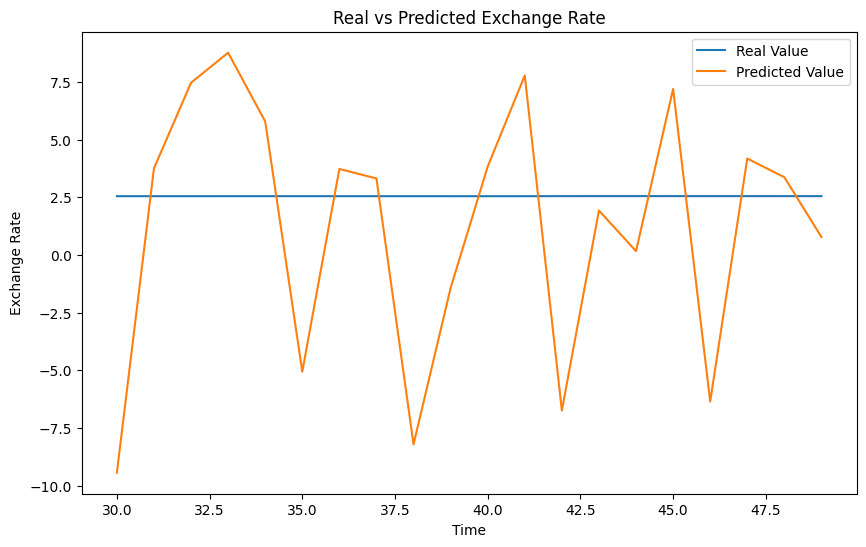

1/1 [==============================] - 0s 56ms/step
prediction [[1.1207389]]
   real_value predicted_value  absolute Error
0    2.546317     [-441477.5]   441480.031250
1    2.546317     [7243.0967]     7240.550293
2    2.545834    [-19825.227]    19827.771484
3    2.547772     [-3798.946]     3801.493896
4    2.547772     [-528.8472]      531.395020
5    2.547772      [898.2568]      895.708984
6    2.548628     [-901.3606]      903.909241
7    2.548628     [5.0158896]        2.467261
8    2.546562    [-16.238266]       18.784828
9    2.546562     [224.07607]      221.529495
10   2.545871     [444.37958]      441.833710
11   2.545094     [220.54985]      218.004761
12   2.545094     [66.666794]       64.121704
13    2.54594   [-10.8755045]       13.421444
14   2.545197     [147.49713]      144.951935
15   2.545197    [-29.062845]       31.608042
16   2.545197      [66.65635]       64.111153
17   2.545016     [19.024704]       16.479689
18   2.545705      [42.29437]       39.748665
19 

<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


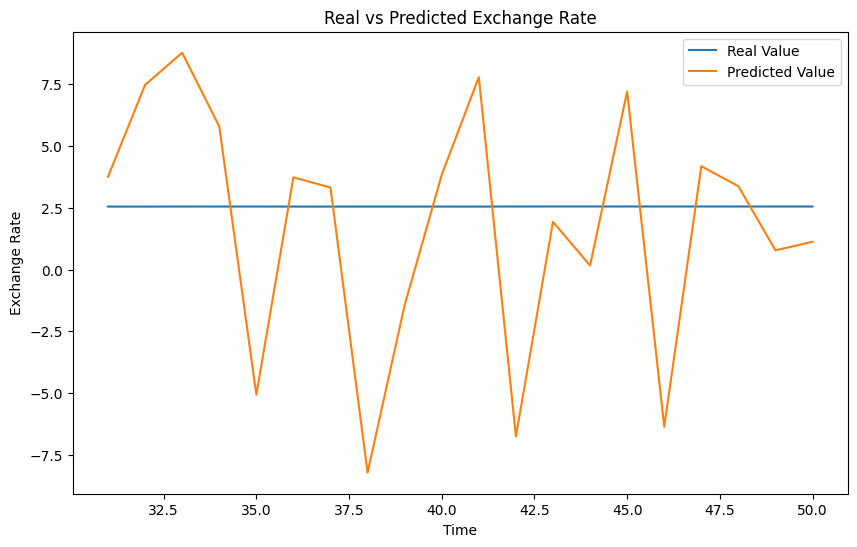

1/1 [==============================] - 0s 51ms/step
prediction [[5.3668494]]
   real_value predicted_value  absolute Error
0    2.546317     [-441477.5]   441480.031250
1    2.546317     [7243.0967]     7240.550293
2    2.545834    [-19825.227]    19827.771484
3    2.547772     [-3798.946]     3801.493896
4    2.547772     [-528.8472]      531.395020
5    2.547772      [898.2568]      895.708984
6    2.548628     [-901.3606]      903.909241
7    2.548628     [5.0158896]        2.467261
8    2.546562    [-16.238266]       18.784828
9    2.546562     [224.07607]      221.529495
10   2.545871     [444.37958]      441.833710
11   2.545094     [220.54985]      218.004761
12   2.545094     [66.666794]       64.121704
13    2.54594   [-10.8755045]       13.421444
14   2.545197     [147.49713]      144.951935
15   2.545197    [-29.062845]       31.608042
16   2.545197      [66.65635]       64.111153
17   2.545016     [19.024704]       16.479689
18   2.545705      [42.29437]       39.748665
19 

<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 54ms/step
prediction [[-1.7150532]]
   real_value predicted_value  absolute Error
0    2.546317     [-441477.5]   441480.031250
1    2.546317     [7243.0967]     7240.550293
2    2.545834    [-19825.227]    19827.771484
3    2.547772     [-3798.946]     3801.493896
4    2.547772     [-528.8472]      531.395020
5    2.547772      [898.2568]      895.708984
6    2.548628     [-901.3606]      903.909241
7    2.548628     [5.0158896]        2.467261
8    2.546562    [-16.238266]       18.784828
9    2.546562     [224.07607]      221.529495
10   2.545871     [444.37958]      441.833710
11   2.545094     [220.54985]      218.004761
12   2.545094     [66.666794]       64.121704
13    2.54594   [-10.8755045]       13.421444
14   2.545197     [147.49713]      144.951935
15   2.545197    [-29.062845]       31.608042
16   2.545197      [66.65635]       64.111153
17   2.545016     [19.024704]       16.479689
18   2.545705      [42.29437]       39.748665
19

<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 56ms/step
prediction [[0.14732957]]
   real_value predicted_value  absolute Error
0    2.546317     [-441477.5]   441480.031250
1    2.546317     [7243.0967]     7240.550293
2    2.545834    [-19825.227]    19827.771484
3    2.547772     [-3798.946]     3801.493896
4    2.547772     [-528.8472]      531.395020
5    2.547772      [898.2568]      895.708984
6    2.548628     [-901.3606]      903.909241
7    2.548628     [5.0158896]        2.467261
8    2.546562    [-16.238266]       18.784828
9    2.546562     [224.07607]      221.529495
10   2.545871     [444.37958]      441.833710
11   2.545094     [220.54985]      218.004761
12   2.545094     [66.666794]       64.121704
13    2.54594   [-10.8755045]       13.421444
14   2.545197     [147.49713]      144.951935
15   2.545197    [-29.062845]       31.608042
16   2.545197      [66.65635]       64.111153
17   2.545016     [19.024704]       16.479689
18   2.545705      [42.29437]       39.748665
19

<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 59ms/step
prediction [[-1.7907546]]
   real_value predicted_value  absolute Error
0    2.546317     [-441477.5]   441480.031250
1    2.546317     [7243.0967]     7240.550293
2    2.545834    [-19825.227]    19827.771484
3    2.547772     [-3798.946]     3801.493896
4    2.547772     [-528.8472]      531.395020
5    2.547772      [898.2568]      895.708984
6    2.548628     [-901.3606]      903.909241
7    2.548628     [5.0158896]        2.467261
8    2.546562    [-16.238266]       18.784828
9    2.546562     [224.07607]      221.529495
10   2.545871     [444.37958]      441.833710
11   2.545094     [220.54985]      218.004761
12   2.545094     [66.666794]       64.121704
13    2.54594   [-10.8755045]       13.421444
14   2.545197     [147.49713]      144.951935
15   2.545197    [-29.062845]       31.608042
16   2.545197      [66.65635]       64.111153
17   2.545016     [19.024704]       16.479689
18   2.545705      [42.29437]       39.748665
19

<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 75ms/step
prediction [[1.2519892]]
   real_value predicted_value  absolute Error
0    2.546317     [-441477.5]   441480.031250
1    2.546317     [7243.0967]     7240.550293
2    2.545834    [-19825.227]    19827.771484
3    2.547772     [-3798.946]     3801.493896
4    2.547772     [-528.8472]      531.395020
5    2.547772      [898.2568]      895.708984
6    2.548628     [-901.3606]      903.909241
7    2.548628     [5.0158896]        2.467261
8    2.546562    [-16.238266]       18.784828
9    2.546562     [224.07607]      221.529495
10   2.545871     [444.37958]      441.833710
11   2.545094     [220.54985]      218.004761
12   2.545094     [66.666794]       64.121704
13    2.54594   [-10.8755045]       13.421444
14   2.545197     [147.49713]      144.951935
15   2.545197    [-29.062845]       31.608042
16   2.545197      [66.65635]       64.111153
17   2.545016     [19.024704]       16.479689
18   2.545705      [42.29437]       39.748665
19 

<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 107ms/step
prediction [[0.08041825]]
   real_value predicted_value  absolute Error
0    2.546317     [-441477.5]   441480.031250
1    2.546317     [7243.0967]     7240.550293
2    2.545834    [-19825.227]    19827.771484
3    2.547772     [-3798.946]     3801.493896
4    2.547772     [-528.8472]      531.395020
5    2.547772      [898.2568]      895.708984
6    2.548628     [-901.3606]      903.909241
7    2.548628     [5.0158896]        2.467261
8    2.546562    [-16.238266]       18.784828
9    2.546562     [224.07607]      221.529495
10   2.545871     [444.37958]      441.833710
11   2.545094     [220.54985]      218.004761
12   2.545094     [66.666794]       64.121704
13    2.54594   [-10.8755045]       13.421444
14   2.545197     [147.49713]      144.951935
15   2.545197    [-29.062845]       31.608042
16   2.545197      [66.65635]       64.111153
17   2.545016     [19.024704]       16.479689
18   2.545705      [42.29437]       39.748665
1

<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 51ms/step
prediction [[0.63427246]]
   real_value predicted_value  absolute Error
0    2.546317     [-441477.5]   441480.031250
1    2.546317     [7243.0967]     7240.550293
2    2.545834    [-19825.227]    19827.771484
3    2.547772     [-3798.946]     3801.493896
4    2.547772     [-528.8472]      531.395020
5    2.547772      [898.2568]      895.708984
6    2.548628     [-901.3606]      903.909241
7    2.548628     [5.0158896]        2.467261
8    2.546562    [-16.238266]       18.784828
9    2.546562     [224.07607]      221.529495
10   2.545871     [444.37958]      441.833710
11   2.545094     [220.54985]      218.004761
12   2.545094     [66.666794]       64.121704
13    2.54594   [-10.8755045]       13.421444
14   2.545197     [147.49713]      144.951935
15   2.545197    [-29.062845]       31.608042
16   2.545197      [66.65635]       64.111153
17   2.545016     [19.024704]       16.479689
18   2.545705      [42.29437]       39.748665
19

<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 54ms/step
prediction [[2.1834085]]
   real_value predicted_value  absolute Error
0    2.546317     [-441477.5]   441480.031250
1    2.546317     [7243.0967]     7240.550293
2    2.545834    [-19825.227]    19827.771484
3    2.547772     [-3798.946]     3801.493896
4    2.547772     [-528.8472]      531.395020
5    2.547772      [898.2568]      895.708984
6    2.548628     [-901.3606]      903.909241
7    2.548628     [5.0158896]        2.467261
8    2.546562    [-16.238266]       18.784828
9    2.546562     [224.07607]      221.529495
10   2.545871     [444.37958]      441.833710
11   2.545094     [220.54985]      218.004761
12   2.545094     [66.666794]       64.121704
13    2.54594   [-10.8755045]       13.421444
14   2.545197     [147.49713]      144.951935
15   2.545197    [-29.062845]       31.608042
16   2.545197      [66.65635]       64.111153
17   2.545016     [19.024704]       16.479689
18   2.545705      [42.29437]       39.748665
19 

<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 56ms/step
prediction [[3.0417962]]
   real_value predicted_value  absolute Error
0    2.546317     [-441477.5]   441480.031250
1    2.546317     [7243.0967]     7240.550293
2    2.545834    [-19825.227]    19827.771484
3    2.547772     [-3798.946]     3801.493896
4    2.547772     [-528.8472]      531.395020
5    2.547772      [898.2568]      895.708984
6    2.548628     [-901.3606]      903.909241
7    2.548628     [5.0158896]        2.467261
8    2.546562    [-16.238266]       18.784828
9    2.546562     [224.07607]      221.529495
10   2.545871     [444.37958]      441.833710
11   2.545094     [220.54985]      218.004761
12   2.545094     [66.666794]       64.121704
13    2.54594   [-10.8755045]       13.421444
14   2.545197     [147.49713]      144.951935
15   2.545197    [-29.062845]       31.608042
16   2.545197      [66.65635]       64.111153
17   2.545016     [19.024704]       16.479689
18   2.545705      [42.29437]       39.748665
19 

<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


Error fetching forex exchange details: could not convert string to float: '-'
1/1 [==============================] - 0s 58ms/step
prediction [[4.4801774]]
   real_value predicted_value  absolute Error
0    2.546317     [-441477.5]   441480.031250
1    2.546317     [7243.0967]     7240.550293
2    2.545834    [-19825.227]    19827.771484
3    2.547772     [-3798.946]     3801.493896
4    2.547772     [-528.8472]      531.395020
..        ...             ...             ...
56   2.545561    [0.08041825]        2.465143
57   2.546248    [0.63427246]        1.911976
58   2.546248     [2.1834085]        0.362840
59   2.546271     [3.0417962]        0.495525
60        NaN     [4.4801774]             NaN

[61 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 54ms/step
prediction [[3.7716398]]
   real_value predicted_value  absolute Error
0    2.546317     [-441477.5]   441480.031250
1    2.546317     [7243.0967]     7240.550293
2    2.545834    [-19825.227]    19827.771484
3    2.547772     [-3798.946]     3801.493896
4    2.547772     [-528.8472]      531.395020
..        ...             ...             ...
57   2.546248    [0.63427246]        1.911976
58   2.546248     [2.1834085]        0.362840
59   2.546271     [3.0417962]        0.495525
60   2.546271     [4.4801774]        1.933906
61        NaN     [3.7716398]             NaN

[62 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 60ms/step
prediction [[0.22827967]]
   real_value predicted_value  absolute Error
0    2.546317     [-441477.5]   441480.031250
1    2.546317     [7243.0967]     7240.550293
2    2.545834    [-19825.227]    19827.771484
3    2.547772     [-3798.946]     3801.493896
4    2.547772     [-528.8472]      531.395020
..        ...             ...             ...
58   2.546248     [2.1834085]        0.362840
59   2.546271     [3.0417962]        0.495525
60   2.546271     [4.4801774]        1.933906
61   2.545998     [3.7716398]        1.225642
62        NaN    [0.22827967]             NaN

[63 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 56ms/step
prediction [[0.7010083]]
   real_value predicted_value  absolute Error
0    2.546317     [-441477.5]   441480.031250
1    2.546317     [7243.0967]     7240.550293
2    2.545834    [-19825.227]    19827.771484
3    2.547772     [-3798.946]     3801.493896
4    2.547772     [-528.8472]      531.395020
..        ...             ...             ...
59   2.546271     [3.0417962]        0.495525
60   2.546271     [4.4801774]        1.933906
61   2.545998     [3.7716398]        1.225642
62   2.545998    [0.22827967]        2.317719
63        NaN     [0.7010083]             NaN

[64 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 86ms/step
prediction [[2.9375458]]
   real_value predicted_value  absolute Error
0    2.546317     [-441477.5]   441480.031250
1    2.546317     [7243.0967]     7240.550293
2    2.545834    [-19825.227]    19827.771484
3    2.547772     [-3798.946]     3801.493896
4    2.547772     [-528.8472]      531.395020
..        ...             ...             ...
60   2.546271     [4.4801774]        1.933906
61   2.545998     [3.7716398]        1.225642
62   2.545998    [0.22827967]        2.317719
63   2.544852     [0.7010083]        1.843844
64        NaN     [2.9375458]             NaN

[65 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 54ms/step
prediction [[2.892243]]
   real_value predicted_value  absolute Error
0    2.546317     [-441477.5]   441480.031250
1    2.546317     [7243.0967]     7240.550293
2    2.545834    [-19825.227]    19827.771484
3    2.547772     [-3798.946]     3801.493896
4    2.547772     [-528.8472]      531.395020
..        ...             ...             ...
61   2.545998     [3.7716398]        1.225642
62   2.545998    [0.22827967]        2.317719
63   2.544852     [0.7010083]        1.843844
64   2.544852     [2.9375458]        0.392693
65        NaN      [2.892243]             NaN

[66 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 55ms/step
prediction [[3.3901994]]
   real_value predicted_value  absolute Error
0    2.546317     [-441477.5]   441480.031250
1    2.546317     [7243.0967]     7240.550293
2    2.545834    [-19825.227]    19827.771484
3    2.547772     [-3798.946]     3801.493896
4    2.547772     [-528.8472]      531.395020
..        ...             ...             ...
62   2.545998    [0.22827967]        2.317719
63   2.544852     [0.7010083]        1.843844
64   2.544852     [2.9375458]        0.392693
65   2.544577      [2.892243]        0.347666
66        NaN     [3.3901994]             NaN

[67 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 61ms/step
prediction [[2.0561166]]
   real_value predicted_value  absolute Error
0    2.546317     [-441477.5]   441480.031250
1    2.546317     [7243.0967]     7240.550293
2    2.545834    [-19825.227]    19827.771484
3    2.547772     [-3798.946]     3801.493896
4    2.547772     [-528.8472]      531.395020
..        ...             ...             ...
63   2.544852     [0.7010083]        1.843844
64   2.544852     [2.9375458]        0.392693
65   2.544577      [2.892243]        0.347666
66   2.545037     [3.3901994]        0.845162
67        NaN     [2.0561166]             NaN

[68 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 54ms/step
prediction [[1.6274866]]
   real_value predicted_value  absolute Error
0    2.546317     [-441477.5]   441480.031250
1    2.546317     [7243.0967]     7240.550293
2    2.545834    [-19825.227]    19827.771484
3    2.547772     [-3798.946]     3801.493896
4    2.547772     [-528.8472]      531.395020
..        ...             ...             ...
64   2.544852     [2.9375458]        0.392693
65   2.544577      [2.892243]        0.347666
66   2.545037     [3.3901994]        0.845162
67   2.545037     [2.0561166]        0.488920
68        NaN     [1.6274866]             NaN

[69 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 86ms/step
prediction [[0.8401892]]
   real_value predicted_value  absolute Error
0    2.546317     [-441477.5]   441480.031250
1    2.546317     [7243.0967]     7240.550293
2    2.545834    [-19825.227]    19827.771484
3    2.547772     [-3798.946]     3801.493896
4    2.547772     [-528.8472]      531.395020
..        ...             ...             ...
65   2.544577      [2.892243]        0.347666
66   2.545037     [3.3901994]        0.845162
67   2.545037     [2.0561166]        0.488920
68   2.545036     [1.6274866]        0.917549
69        NaN     [0.8401892]             NaN

[70 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 89ms/step
prediction [[1.4480152]]
   real_value predicted_value  absolute Error
0    2.546317     [-441477.5]   441480.031250
1    2.546317     [7243.0967]     7240.550293
2    2.545834    [-19825.227]    19827.771484
3    2.547772     [-3798.946]     3801.493896
4    2.547772     [-528.8472]      531.395020
..        ...             ...             ...
66   2.545037     [3.3901994]        0.845162
67   2.545037     [2.0561166]        0.488920
68   2.545036     [1.6274866]        0.917549
69   2.544928     [0.8401892]        1.704739
70        NaN     [1.4480152]             NaN

[71 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 58ms/step
prediction [[3.296802]]
   real_value predicted_value  absolute Error
0    2.546317     [-441477.5]   441480.031250
1    2.546317     [7243.0967]     7240.550293
2    2.545834    [-19825.227]    19827.771484
3    2.547772     [-3798.946]     3801.493896
4    2.547772     [-528.8472]      531.395020
..        ...             ...             ...
67   2.545037     [2.0561166]        0.488920
68   2.545036     [1.6274866]        0.917549
69   2.544928     [0.8401892]        1.704739
70   2.544928     [1.4480152]        1.096913
71        NaN      [3.296802]             NaN

[72 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 54ms/step
prediction [[3.40807]]
   real_value predicted_value  absolute Error
0    2.546317     [-441477.5]   441480.031250
1    2.546317     [7243.0967]     7240.550293
2    2.545834    [-19825.227]    19827.771484
3    2.547772     [-3798.946]     3801.493896
4    2.547772     [-528.8472]      531.395020
..        ...             ...             ...
68   2.545036     [1.6274866]        0.917549
69   2.544928     [0.8401892]        1.704739
70   2.544928     [1.4480152]        1.096913
71   2.544927      [3.296802]        0.751875
72        NaN       [3.40807]             NaN

[73 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 57ms/step
prediction [[1.9711564]]
   real_value predicted_value  absolute Error
0    2.546317     [-441477.5]   441480.031250
1    2.546317     [7243.0967]     7240.550293
2    2.545834    [-19825.227]    19827.771484
3    2.547772     [-3798.946]     3801.493896
4    2.547772     [-528.8472]      531.395020
..        ...             ...             ...
69   2.544928     [0.8401892]        1.704739
70   2.544928     [1.4480152]        1.096913
71   2.544927      [3.296802]        0.751875
72   2.544927       [3.40807]        0.863143
73        NaN     [1.9711564]             NaN

[74 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 54ms/step
prediction [[1.9725568]]
   real_value predicted_value  absolute Error
0    2.546317     [-441477.5]   441480.031250
1    2.546317     [7243.0967]     7240.550293
2    2.545834    [-19825.227]    19827.771484
3    2.547772     [-3798.946]     3801.493896
4    2.547772     [-528.8472]      531.395020
..        ...             ...             ...
70   2.544928     [1.4480152]        1.096913
71   2.544927      [3.296802]        0.751875
72   2.544927       [3.40807]        0.863143
73   2.543722     [1.9711564]        0.572566
74        NaN     [1.9725568]             NaN

[75 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 66ms/step
prediction [[4.109227]]
   real_value predicted_value  absolute Error
0    2.546317     [-441477.5]   441480.031250
1    2.546317     [7243.0967]     7240.550293
2    2.545834    [-19825.227]    19827.771484
3    2.547772     [-3798.946]     3801.493896
4    2.547772     [-528.8472]      531.395020
..        ...             ...             ...
71   2.544927      [3.296802]        0.751875
72   2.544927       [3.40807]        0.863143
73   2.543722     [1.9711564]        0.572566
74   2.543722     [1.9725568]        0.571166
75        NaN      [4.109227]             NaN

[76 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 91ms/step
prediction [[-0.5125566]]
   real_value predicted_value  absolute Error
0    2.546317     [-441477.5]   441480.031250
1    2.546317     [7243.0967]     7240.550293
2    2.545834    [-19825.227]    19827.771484
3    2.547772     [-3798.946]     3801.493896
4    2.547772     [-528.8472]      531.395020
..        ...             ...             ...
72   2.544927       [3.40807]        0.863143
73   2.543722     [1.9711564]        0.572566
74   2.543722     [1.9725568]        0.571166
75   2.543722      [4.109227]        1.565505
76        NaN    [-0.5125566]             NaN

[77 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 67ms/step
prediction [[2.8416429]]
   real_value predicted_value  absolute Error
0    2.546317     [-441477.5]   441480.031250
1    2.546317     [7243.0967]     7240.550293
2    2.545834    [-19825.227]    19827.771484
3    2.547772     [-3798.946]     3801.493896
4    2.547772     [-528.8472]      531.395020
..        ...             ...             ...
73   2.543722     [1.9711564]        0.572566
74   2.543722     [1.9725568]        0.571166
75   2.543722      [4.109227]        1.565505
76   2.543613    [-0.5125566]        3.056170
77        NaN     [2.8416429]             NaN

[78 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 68ms/step
prediction [[6.192752]]
   real_value predicted_value  absolute Error
0    2.546317     [-441477.5]   441480.031250
1    2.546317     [7243.0967]     7240.550293
2    2.545834    [-19825.227]    19827.771484
3    2.547772     [-3798.946]     3801.493896
4    2.547772     [-528.8472]      531.395020
..        ...             ...             ...
74   2.543722     [1.9725568]        0.571166
75   2.543722      [4.109227]        1.565505
76   2.543613    [-0.5125566]        3.056170
77   2.543613     [2.8416429]        0.298030
78        NaN      [6.192752]             NaN

[79 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


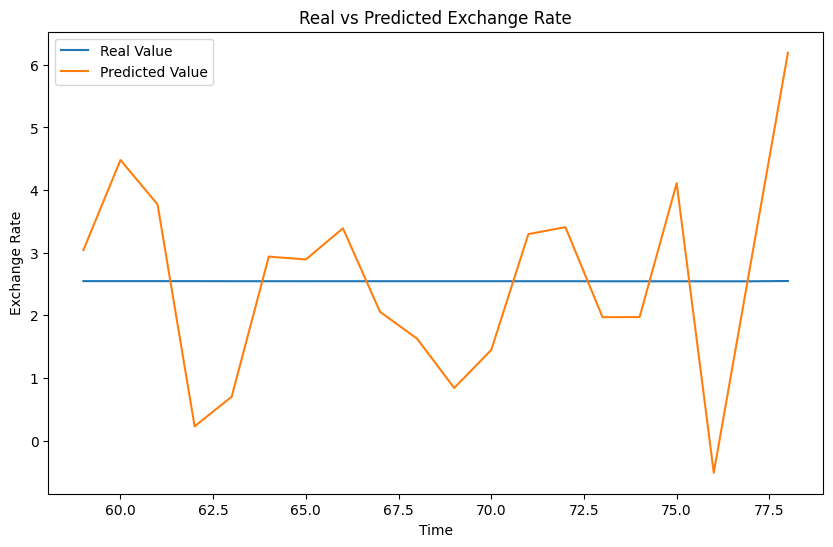

1/1 [==============================] - 0s 69ms/step
prediction [[2.9176455]]
   real_value predicted_value  absolute Error
0    2.546317     [-441477.5]   441480.031250
1    2.546317     [7243.0967]     7240.550293
2    2.545834    [-19825.227]    19827.771484
3    2.547772     [-3798.946]     3801.493896
4    2.547772     [-528.8472]      531.395020
..        ...             ...             ...
75   2.543722      [4.109227]        1.565505
76   2.543613    [-0.5125566]        3.056170
77   2.543613     [2.8416429]        0.298030
78   2.548162      [6.192752]        3.644589
79        NaN     [2.9176455]             NaN

[80 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 64ms/step
prediction [[4.599964]]
   real_value predicted_value  absolute Error
0    2.546317     [-441477.5]   441480.031250
1    2.546317     [7243.0967]     7240.550293
2    2.545834    [-19825.227]    19827.771484
3    2.547772     [-3798.946]     3801.493896
4    2.547772     [-528.8472]      531.395020
..        ...             ...             ...
76   2.543613    [-0.5125566]        3.056170
77   2.543613     [2.8416429]        0.298030
78   2.548162      [6.192752]        3.644589
79   2.547458     [2.9176455]        0.370188
80        NaN      [4.599964]             NaN

[81 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 63ms/step
prediction [[3.2545686]]
   real_value predicted_value  absolute Error
0    2.546317     [-441477.5]   441480.031250
1    2.546317     [7243.0967]     7240.550293
2    2.545834    [-19825.227]    19827.771484
3    2.547772     [-3798.946]     3801.493896
4    2.547772     [-528.8472]      531.395020
..        ...             ...             ...
77   2.543613     [2.8416429]        0.298030
78   2.548162      [6.192752]        3.644589
79   2.547458     [2.9176455]        0.370188
80   2.547458      [4.599964]        2.052506
81        NaN     [3.2545686]             NaN

[82 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 101ms/step
prediction [[0.41519958]]
   real_value predicted_value  absolute Error
0    2.546317     [-441477.5]   441480.031250
1    2.546317     [7243.0967]     7240.550293
2    2.545834    [-19825.227]    19827.771484
3    2.547772     [-3798.946]     3801.493896
4    2.547772     [-528.8472]      531.395020
..        ...             ...             ...
78   2.548162      [6.192752]        3.644589
79   2.547458     [2.9176455]        0.370188
80   2.547458      [4.599964]        2.052506
81   2.547475     [3.2545686]        0.707093
82        NaN    [0.41519958]             NaN

[83 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 88ms/step
prediction [[0.6844943]]
   real_value predicted_value  absolute Error
0    2.546317     [-441477.5]   441480.031250
1    2.546317     [7243.0967]     7240.550293
2    2.545834    [-19825.227]    19827.771484
3    2.547772     [-3798.946]     3801.493896
4    2.547772     [-528.8472]      531.395020
..        ...             ...             ...
79   2.547458     [2.9176455]        0.370188
80   2.547458      [4.599964]        2.052506
81   2.547475     [3.2545686]        0.707093
82   2.547351    [0.41519958]        2.132151
83        NaN     [0.6844943]             NaN

[84 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 63ms/step
prediction [[5.0500245]]
   real_value predicted_value  absolute Error
0    2.546317     [-441477.5]   441480.031250
1    2.546317     [7243.0967]     7240.550293
2    2.545834    [-19825.227]    19827.771484
3    2.547772     [-3798.946]     3801.493896
4    2.547772     [-528.8472]      531.395020
..        ...             ...             ...
80   2.547458      [4.599964]        2.052506
81   2.547475     [3.2545686]        0.707093
82   2.547351    [0.41519958]        2.132151
83   2.547351     [0.6844943]        1.862856
84        NaN     [5.0500245]             NaN

[85 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


Error fetching forex exchange details: could not convert string to float: '-'
1/1 [==============================] - 0s 82ms/step
prediction [[2.7271767]]
   real_value predicted_value  absolute Error
0    2.546317     [-441477.5]   441480.031250
1    2.546317     [7243.0967]     7240.550293
2    2.545834    [-19825.227]    19827.771484
3    2.547772     [-3798.946]     3801.493896
4    2.547772     [-528.8472]      531.395020
..        ...             ...             ...
81   2.547475     [3.2545686]        0.707093
82   2.547351    [0.41519958]        2.132151
83   2.547351     [0.6844943]        1.862856
84   2.547803     [5.0500245]        2.502221
85        NaN     [2.7271767]             NaN

[86 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 69ms/step
prediction [[2.909757]]
   real_value predicted_value  absolute Error
0    2.546317     [-441477.5]   441480.031250
1    2.546317     [7243.0967]     7240.550293
2    2.545834    [-19825.227]    19827.771484
3    2.547772     [-3798.946]     3801.493896
4    2.547772     [-528.8472]      531.395020
..        ...             ...             ...
82   2.547351    [0.41519958]        2.132151
83   2.547351     [0.6844943]        1.862856
84   2.547803     [5.0500245]        2.502221
85   2.547328     [2.7271767]        0.179848
86        NaN      [2.909757]             NaN

[87 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 67ms/step
prediction [[4.967086]]
   real_value predicted_value  absolute Error
0    2.546317     [-441477.5]   441480.031250
1    2.546317     [7243.0967]     7240.550293
2    2.545834    [-19825.227]    19827.771484
3    2.547772     [-3798.946]     3801.493896
4    2.547772     [-528.8472]      531.395020
..        ...             ...             ...
83   2.547351     [0.6844943]        1.862856
84   2.547803     [5.0500245]        2.502221
85   2.547328     [2.7271767]        0.179848
86    2.54715      [2.909757]        0.362607
87        NaN      [4.967086]             NaN

[88 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 68ms/step
prediction [[1.3302164]]
   real_value predicted_value  absolute Error
0    2.546317     [-441477.5]   441480.031250
1    2.546317     [7243.0967]     7240.550293
2    2.545834    [-19825.227]    19827.771484
3    2.547772     [-3798.946]     3801.493896
4    2.547772     [-528.8472]      531.395020
..        ...             ...             ...
84   2.547803     [5.0500245]        2.502221
85   2.547328     [2.7271767]        0.179848
86    2.54715      [2.909757]        0.362607
87    2.54715      [4.967086]        2.419935
88        NaN     [1.3302164]             NaN

[89 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 61ms/step
prediction [[4.11884]]
   real_value predicted_value  absolute Error
0    2.546317     [-441477.5]   441480.031250
1    2.546317     [7243.0967]     7240.550293
2    2.545834    [-19825.227]    19827.771484
3    2.547772     [-3798.946]     3801.493896
4    2.547772     [-528.8472]      531.395020
..        ...             ...             ...
85   2.547328     [2.7271767]        0.179848
86    2.54715      [2.909757]        0.362607
87    2.54715      [4.967086]        2.419935
88   2.546521     [1.3302164]        1.216305
89        NaN       [4.11884]             NaN

[90 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 61ms/step
prediction [[4.014231]]
   real_value predicted_value  absolute Error
0    2.546317     [-441477.5]   441480.031250
1    2.546317     [7243.0967]     7240.550293
2    2.545834    [-19825.227]    19827.771484
3    2.547772     [-3798.946]     3801.493896
4    2.547772     [-528.8472]      531.395020
..        ...             ...             ...
86    2.54715      [2.909757]        0.362607
87    2.54715      [4.967086]        2.419935
88   2.546521     [1.3302164]        1.216305
89   2.546521       [4.11884]        1.572319
90        NaN      [4.014231]             NaN

[91 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 62ms/step
prediction [[1.482052]]
   real_value predicted_value  absolute Error
0    2.546317     [-441477.5]   441480.031250
1    2.546317     [7243.0967]     7240.550293
2    2.545834    [-19825.227]    19827.771484
3    2.547772     [-3798.946]     3801.493896
4    2.547772     [-528.8472]      531.395020
..        ...             ...             ...
87    2.54715      [4.967086]        2.419935
88   2.546521     [1.3302164]        1.216305
89   2.546521       [4.11884]        1.572319
90   2.546521      [4.014231]        1.467710
91        NaN      [1.482052]             NaN

[92 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 88ms/step
prediction [[4.1178236]]
   real_value predicted_value  absolute Error
0    2.546317     [-441477.5]   441480.031250
1    2.546317     [7243.0967]     7240.550293
2    2.545834    [-19825.227]    19827.771484
3    2.547772     [-3798.946]     3801.493896
4    2.547772     [-528.8472]      531.395020
..        ...             ...             ...
88   2.546521     [1.3302164]        1.216305
89   2.546521       [4.11884]        1.572319
90   2.546521      [4.014231]        1.467710
91   2.546266      [1.482052]        1.064214
92        NaN     [4.1178236]             NaN

[93 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 65ms/step
prediction [[1.793385]]
   real_value predicted_value  absolute Error
0    2.546317     [-441477.5]   441480.031250
1    2.546317     [7243.0967]     7240.550293
2    2.545834    [-19825.227]    19827.771484
3    2.547772     [-3798.946]     3801.493896
4    2.547772     [-528.8472]      531.395020
..        ...             ...             ...
89   2.546521       [4.11884]        1.572319
90   2.546521      [4.014231]        1.467710
91   2.546266      [1.482052]        1.064214
92   2.546266     [4.1178236]        1.571557
93        NaN      [1.793385]             NaN

[94 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


Error fetching forex exchange details: could not convert string to float: '-'
1/1 [==============================] - 0s 63ms/step
prediction [[2.7263699]]
   real_value predicted_value  absolute Error
0    2.546317     [-441477.5]   441480.031250
1    2.546317     [7243.0967]     7240.550293
2    2.545834    [-19825.227]    19827.771484
3    2.547772     [-3798.946]     3801.493896
4    2.547772     [-528.8472]      531.395020
..        ...             ...             ...
90   2.546521      [4.014231]        1.467710
91   2.546266      [1.482052]        1.064214
92   2.546266     [4.1178236]        1.571557
93   2.545979      [1.793385]        0.752594
94        NaN     [2.7263699]             NaN

[95 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 68ms/step
prediction [[3.4891686]]
   real_value predicted_value  absolute Error
0    2.546317     [-441477.5]   441480.031250
1    2.546317     [7243.0967]     7240.550293
2    2.545834    [-19825.227]    19827.771484
3    2.547772     [-3798.946]     3801.493896
4    2.547772     [-528.8472]      531.395020
..        ...             ...             ...
91   2.546266      [1.482052]        1.064214
92   2.546266     [4.1178236]        1.571557
93   2.545979      [1.793385]        0.752594
94   2.545979     [2.7263699]        0.180391
95        NaN     [3.4891686]             NaN

[96 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 67ms/step
prediction [[3.2725182]]
   real_value predicted_value  absolute Error
0    2.546317     [-441477.5]   441480.031250
1    2.546317     [7243.0967]     7240.550293
2    2.545834    [-19825.227]    19827.771484
3    2.547772     [-3798.946]     3801.493896
4    2.547772     [-528.8472]      531.395020
..        ...             ...             ...
92   2.546266     [4.1178236]        1.571557
93   2.545979      [1.793385]        0.752594
94   2.545979     [2.7263699]        0.180391
95   2.545979     [3.4891686]        0.943189
96        NaN     [3.2725182]             NaN

[97 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 64ms/step
prediction [[-0.7642466]]
   real_value predicted_value  absolute Error
0    2.546317     [-441477.5]   441480.031250
1    2.546317     [7243.0967]     7240.550293
2    2.545834    [-19825.227]    19827.771484
3    2.547772     [-3798.946]     3801.493896
4    2.547772     [-528.8472]      531.395020
..        ...             ...             ...
93   2.545979      [1.793385]        0.752594
94   2.545979     [2.7263699]        0.180391
95   2.545979     [3.4891686]        0.943189
96   2.547311     [3.2725182]        0.725207
97        NaN    [-0.7642466]             NaN

[98 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 66ms/step
prediction [[0.5368122]]
   real_value predicted_value  absolute Error
0    2.546317     [-441477.5]   441480.031250
1    2.546317     [7243.0967]     7240.550293
2    2.545834    [-19825.227]    19827.771484
3    2.547772     [-3798.946]     3801.493896
4    2.547772     [-528.8472]      531.395020
..        ...             ...             ...
94   2.545979     [2.7263699]        0.180391
95   2.545979     [3.4891686]        0.943189
96   2.547311     [3.2725182]        0.725207
97   2.547311    [-0.7642466]        3.311558
98        NaN     [0.5368122]             NaN

[99 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 102ms/step
prediction [[2.1077116]]
   real_value predicted_value  absolute Error
0    2.546317     [-441477.5]   441480.031250
1    2.546317     [7243.0967]     7240.550293
2    2.545834    [-19825.227]    19827.771484
3    2.547772     [-3798.946]     3801.493896
4    2.547772     [-528.8472]      531.395020
..        ...             ...             ...
95   2.545979     [3.4891686]        0.943189
96   2.547311     [3.2725182]        0.725207
97   2.547311    [-0.7642466]        3.311558
98   2.546066     [0.5368122]        2.009254
99        NaN     [2.1077116]             NaN

[100 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 73ms/step
prediction [[3.0863051]]
    real_value predicted_value  absolute Error
0     2.546317     [-441477.5]   441480.031250
1     2.546317     [7243.0967]     7240.550293
2     2.545834    [-19825.227]    19827.771484
3     2.547772     [-3798.946]     3801.493896
4     2.547772     [-528.8472]      531.395020
..         ...             ...             ...
96    2.547311     [3.2725182]        0.725207
97    2.547311    [-0.7642466]        3.311558
98    2.546066     [0.5368122]        2.009254
99    2.546066     [2.1077116]        0.438355
100        NaN     [3.0863051]             NaN

[101 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 61ms/step
prediction [[2.518299]]
    real_value predicted_value  absolute Error
0     2.546317     [-441477.5]   441480.031250
1     2.546317     [7243.0967]     7240.550293
2     2.545834    [-19825.227]    19827.771484
3     2.547772     [-3798.946]     3801.493896
4     2.547772     [-528.8472]      531.395020
..         ...             ...             ...
97    2.547311    [-0.7642466]        3.311558
98    2.546066     [0.5368122]        2.009254
99    2.546066     [2.1077116]        0.438355
100   2.545507     [3.0863051]        0.540798
101        NaN      [2.518299]             NaN

[102 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 71ms/step
prediction [[2.1164298]]
    real_value predicted_value  absolute Error
0     2.546317     [-441477.5]   441480.031250
1     2.546317     [7243.0967]     7240.550293
2     2.545834    [-19825.227]    19827.771484
3     2.547772     [-3798.946]     3801.493896
4     2.547772     [-528.8472]      531.395020
..         ...             ...             ...
98    2.546066     [0.5368122]        2.009254
99    2.546066     [2.1077116]        0.438355
100   2.545507     [3.0863051]        0.540798
101   2.546006      [2.518299]        0.027707
102        NaN     [2.1164298]             NaN

[103 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 64ms/step
prediction [[3.434802]]
    real_value predicted_value  absolute Error
0     2.546317     [-441477.5]   441480.031250
1     2.546317     [7243.0967]     7240.550293
2     2.545834    [-19825.227]    19827.771484
3     2.547772     [-3798.946]     3801.493896
4     2.547772     [-528.8472]      531.395020
..         ...             ...             ...
99    2.546066     [2.1077116]        0.438355
100   2.545507     [3.0863051]        0.540798
101   2.546006      [2.518299]        0.027707
102   2.546006     [2.1164298]        0.429577
103        NaN      [3.434802]             NaN

[104 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 66ms/step
prediction [[0.7815813]]
    real_value predicted_value  absolute Error
0     2.546317     [-441477.5]   441480.031250
1     2.546317     [7243.0967]     7240.550293
2     2.545834    [-19825.227]    19827.771484
3     2.547772     [-3798.946]     3801.493896
4     2.547772     [-528.8472]      531.395020
..         ...             ...             ...
100   2.545507     [3.0863051]        0.540798
101   2.546006      [2.518299]        0.027707
102   2.546006     [2.1164298]        0.429577
103   2.546006      [3.434802]        0.888796
104        NaN     [0.7815813]             NaN

[105 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 59ms/step
prediction [[1.6097794]]
    real_value predicted_value  absolute Error
0     2.546317     [-441477.5]   441480.031250
1     2.546317     [7243.0967]     7240.550293
2     2.545834    [-19825.227]    19827.771484
3     2.547772     [-3798.946]     3801.493896
4     2.547772     [-528.8472]      531.395020
..         ...             ...             ...
101   2.546006      [2.518299]        0.027707
102   2.546006     [2.1164298]        0.429577
103   2.546006      [3.434802]        0.888796
104   2.546006     [0.7815813]        1.764425
105        NaN     [1.6097794]             NaN

[106 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 62ms/step
prediction [[4.444698]]
    real_value predicted_value  absolute Error
0     2.546317     [-441477.5]   441480.031250
1     2.546317     [7243.0967]     7240.550293
2     2.545834    [-19825.227]    19827.771484
3     2.547772     [-3798.946]     3801.493896
4     2.547772     [-528.8472]      531.395020
..         ...             ...             ...
102   2.546006     [2.1164298]        0.429577
103   2.546006      [3.434802]        0.888796
104   2.546006     [0.7815813]        1.764425
105   2.546006     [1.6097794]        0.936227
106        NaN      [4.444698]             NaN

[107 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 60ms/step
prediction [[3.4939177]]
    real_value predicted_value  absolute Error
0     2.546317     [-441477.5]   441480.031250
1     2.546317     [7243.0967]     7240.550293
2     2.545834    [-19825.227]    19827.771484
3     2.547772     [-3798.946]     3801.493896
4     2.547772     [-528.8472]      531.395020
..         ...             ...             ...
103   2.546006      [3.434802]        0.888796
104   2.546006     [0.7815813]        1.764425
105   2.546006     [1.6097794]        0.936227
106   2.546006      [4.444698]        1.898691
107        NaN     [3.4939177]             NaN

[108 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 87ms/step
prediction [[3.5495682]]
    real_value predicted_value  absolute Error
0     2.546317     [-441477.5]   441480.031250
1     2.546317     [7243.0967]     7240.550293
2     2.545834    [-19825.227]    19827.771484
3     2.547772     [-3798.946]     3801.493896
4     2.547772     [-528.8472]      531.395020
..         ...             ...             ...
104   2.546006     [0.7815813]        1.764425
105   2.546006     [1.6097794]        0.936227
106   2.546006      [4.444698]        1.898691
107   2.546006     [3.4939177]        0.947911
108        NaN     [3.5495682]             NaN

[109 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 89ms/step
prediction [[2.2526]]
    real_value predicted_value  absolute Error
0     2.546317     [-441477.5]   441480.031250
1     2.546317     [7243.0967]     7240.550293
2     2.545834    [-19825.227]    19827.771484
3     2.547772     [-3798.946]     3801.493896
4     2.547772     [-528.8472]      531.395020
..         ...             ...             ...
105   2.546006     [1.6097794]        0.936227
106   2.546006      [4.444698]        1.898691
107   2.546006     [3.4939177]        0.947911
108   2.545836     [3.5495682]        1.003732
109        NaN        [2.2526]             NaN

[110 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 83ms/step
prediction [[1.2081958]]
    real_value predicted_value  absolute Error
0     2.546317     [-441477.5]   441480.031250
1     2.546317     [7243.0967]     7240.550293
2     2.545834    [-19825.227]    19827.771484
3     2.547772     [-3798.946]     3801.493896
4     2.547772     [-528.8472]      531.395020
..         ...             ...             ...
106   2.546006      [4.444698]        1.898691
107   2.546006     [3.4939177]        0.947911
108   2.545836     [3.5495682]        1.003732
109   2.546304        [2.2526]        0.293704
110        NaN     [1.2081958]             NaN

[111 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 62ms/step
prediction [[2.1844306]]
    real_value predicted_value  absolute Error
0     2.546317     [-441477.5]   441480.031250
1     2.546317     [7243.0967]     7240.550293
2     2.545834    [-19825.227]    19827.771484
3     2.547772     [-3798.946]     3801.493896
4     2.547772     [-528.8472]      531.395020
..         ...             ...             ...
107   2.546006     [3.4939177]        0.947911
108   2.545836     [3.5495682]        1.003732
109   2.546304        [2.2526]        0.293704
110   2.546304     [1.2081958]        1.338108
111        NaN     [2.1844306]             NaN

[112 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


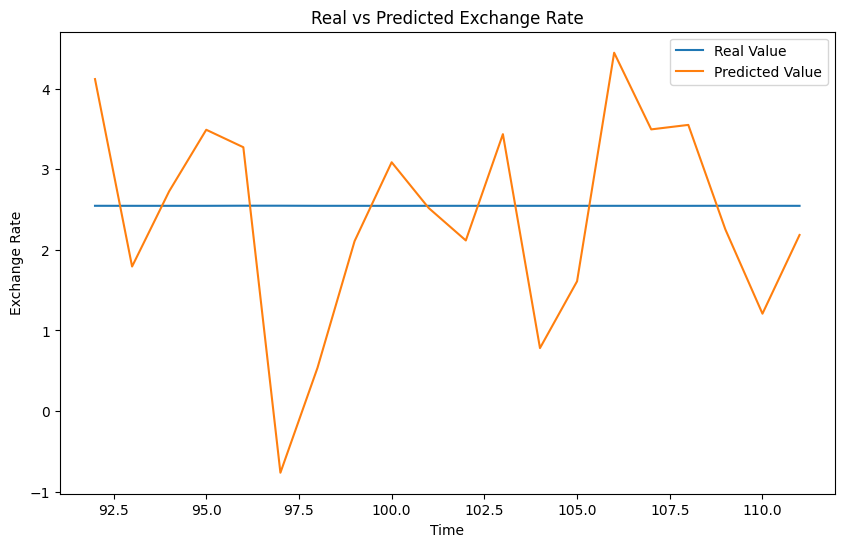

1/1 [==============================] - 0s 58ms/step
prediction [[1.5198792]]
    real_value predicted_value  absolute Error
0     2.546317     [-441477.5]   441480.031250
1     2.546317     [7243.0967]     7240.550293
2     2.545834    [-19825.227]    19827.771484
3     2.547772     [-3798.946]     3801.493896
4     2.547772     [-528.8472]      531.395020
..         ...             ...             ...
108   2.545836     [3.5495682]        1.003732
109   2.546304        [2.2526]        0.293704
110   2.546304     [1.2081958]        1.338108
111   2.545841     [2.1844306]        0.361410
112        NaN     [1.5198792]             NaN

[113 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 54ms/step
prediction [[4.827946]]
    real_value predicted_value  absolute Error
0     2.546317     [-441477.5]   441480.031250
1     2.546317     [7243.0967]     7240.550293
2     2.545834    [-19825.227]    19827.771484
3     2.547772     [-3798.946]     3801.493896
4     2.547772     [-528.8472]      531.395020
..         ...             ...             ...
109   2.546304        [2.2526]        0.293704
110   2.546304     [1.2081958]        1.338108
111   2.545841     [2.1844306]        0.361410
112   2.545666     [1.5198792]        1.025787
113        NaN      [4.827946]             NaN

[114 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 65ms/step
prediction [[2.2311573]]
    real_value predicted_value  absolute Error
0     2.546317     [-441477.5]   441480.031250
1     2.546317     [7243.0967]     7240.550293
2     2.545834    [-19825.227]    19827.771484
3     2.547772     [-3798.946]     3801.493896
4     2.547772     [-528.8472]      531.395020
..         ...             ...             ...
110   2.546304     [1.2081958]        1.338108
111   2.545841     [2.1844306]        0.361410
112   2.545666     [1.5198792]        1.025787
113   2.545666      [4.827946]        2.282280
114        NaN     [2.2311573]             NaN

[115 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 64ms/step
prediction [[2.2222211]]
    real_value predicted_value  absolute Error
0     2.546317     [-441477.5]   441480.031250
1     2.546317     [7243.0967]     7240.550293
2     2.545834    [-19825.227]    19827.771484
3     2.547772     [-3798.946]     3801.493896
4     2.547772     [-528.8472]      531.395020
..         ...             ...             ...
111   2.545841     [2.1844306]        0.361410
112   2.545666     [1.5198792]        1.025787
113   2.545666      [4.827946]        2.282280
114   2.545556     [2.2311573]        0.314399
115        NaN     [2.2222211]             NaN

[116 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 62ms/step
prediction [[2.7545815]]
    real_value predicted_value  absolute Error
0     2.546317     [-441477.5]   441480.031250
1     2.546317     [7243.0967]     7240.550293
2     2.545834    [-19825.227]    19827.771484
3     2.547772     [-3798.946]     3801.493896
4     2.547772     [-528.8472]      531.395020
..         ...             ...             ...
112   2.545666     [1.5198792]        1.025787
113   2.545666      [4.827946]        2.282280
114   2.545556     [2.2311573]        0.314399
115   2.545556     [2.2222211]        0.323335
116        NaN     [2.7545815]             NaN

[117 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 58ms/step
prediction [[1.9206687]]
    real_value predicted_value  absolute Error
0     2.546317     [-441477.5]   441480.031250
1     2.546317     [7243.0967]     7240.550293
2     2.545834    [-19825.227]    19827.771484
3     2.547772     [-3798.946]     3801.493896
4     2.547772     [-528.8472]      531.395020
..         ...             ...             ...
113   2.545666      [4.827946]        2.282280
114   2.545556     [2.2311573]        0.314399
115   2.545556     [2.2222211]        0.323335
116   2.545556     [2.7545815]        0.209025
117        NaN     [1.9206687]             NaN

[118 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 84ms/step
prediction [[2.5780854]]
    real_value predicted_value  absolute Error
0     2.546317     [-441477.5]   441480.031250
1     2.546317     [7243.0967]     7240.550293
2     2.545834    [-19825.227]    19827.771484
3     2.547772     [-3798.946]     3801.493896
4     2.547772     [-528.8472]      531.395020
..         ...             ...             ...
114   2.545556     [2.2311573]        0.314399
115   2.545556     [2.2222211]        0.323335
116   2.545556     [2.7545815]        0.209025
117   2.544441     [1.9206687]        0.623772
118        NaN     [2.5780854]             NaN

[119 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 53ms/step
prediction [[3.2725637]]
    real_value predicted_value  absolute Error
0     2.546317     [-441477.5]   441480.031250
1     2.546317     [7243.0967]     7240.550293
2     2.545834    [-19825.227]    19827.771484
3     2.547772     [-3798.946]     3801.493896
4     2.547772     [-528.8472]      531.395020
..         ...             ...             ...
115   2.545556     [2.2222211]        0.323335
116   2.545556     [2.7545815]        0.209025
117   2.544441     [1.9206687]        0.623772
118   2.544441     [2.5780854]        0.033645
119        NaN     [3.2725637]             NaN

[120 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 54ms/step
prediction [[2.506246]]
    real_value predicted_value  absolute Error
0     2.546317     [-441477.5]   441480.031250
1     2.546317     [7243.0967]     7240.550293
2     2.545834    [-19825.227]    19827.771484
3     2.547772     [-3798.946]     3801.493896
4     2.547772     [-528.8472]      531.395020
..         ...             ...             ...
116   2.545556     [2.7545815]        0.209025
117   2.544441     [1.9206687]        0.623772
118   2.544441     [2.5780854]        0.033645
119   2.544686     [3.2725637]        0.727878
120        NaN      [2.506246]             NaN

[121 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


Error fetching forex exchange details: could not convert string to float: '-'
Error fetching forex exchange details: could not convert string to float: '-'
1/1 [==============================] - 0s 57ms/step
prediction [[2.9057567]]
    real_value predicted_value  absolute Error
0     2.546317     [-441477.5]   441480.031250
1     2.546317     [7243.0967]     7240.550293
2     2.545834    [-19825.227]    19827.771484
3     2.547772     [-3798.946]     3801.493896
4     2.547772     [-528.8472]      531.395020
..         ...             ...             ...
117   2.544441     [1.9206687]        0.623772
118   2.544441     [2.5780854]        0.033645
119   2.544686     [3.2725637]        0.727878
120   2.544523      [2.506246]        0.038277
121        NaN     [2.9057567]             NaN

[122 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 52ms/step
prediction [[3.650181]]
    real_value predicted_value  absolute Error
0     2.546317     [-441477.5]   441480.031250
1     2.546317     [7243.0967]     7240.550293
2     2.545834    [-19825.227]    19827.771484
3     2.547772     [-3798.946]     3801.493896
4     2.547772     [-528.8472]      531.395020
..         ...             ...             ...
118   2.544441     [2.5780854]        0.033645
119   2.544686     [3.2725637]        0.727878
120   2.544523      [2.506246]        0.038277
121   2.544523     [2.9057567]        0.361234
122        NaN      [3.650181]             NaN

[123 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 90ms/step
prediction [[2.2265682]]
    real_value predicted_value  absolute Error
0     2.546317     [-441477.5]   441480.031250
1     2.546317     [7243.0967]     7240.550293
2     2.545834    [-19825.227]    19827.771484
3     2.547772     [-3798.946]     3801.493896
4     2.547772     [-528.8472]      531.395020
..         ...             ...             ...
119   2.544686     [3.2725637]        0.727878
120   2.544523      [2.506246]        0.038277
121   2.544523     [2.9057567]        0.361234
122   2.544843      [3.650181]        1.105338
123        NaN     [2.2265682]             NaN

[124 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


Error fetching forex exchange details: could not convert string to float: '-'
Error fetching forex exchange details: could not convert string to float: '-'
1/1 [==============================] - 0s 56ms/step
prediction [[2.557199]]
    real_value predicted_value  absolute Error
0     2.546317     [-441477.5]   441480.031250
1     2.546317     [7243.0967]     7240.550293
2     2.545834    [-19825.227]    19827.771484
3     2.547772     [-3798.946]     3801.493896
4     2.547772     [-528.8472]      531.395020
..         ...             ...             ...
120   2.544523      [2.506246]        0.038277
121   2.544523     [2.9057567]        0.361234
122   2.544843      [3.650181]        1.105338
123   2.545188     [2.2265682]        0.318620
124        NaN      [2.557199]             NaN

[125 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 82ms/step
prediction [[3.0651402]]
    real_value predicted_value  absolute Error
0     2.546317     [-441477.5]   441480.031250
1     2.546317     [7243.0967]     7240.550293
2     2.545834    [-19825.227]    19827.771484
3     2.547772     [-3798.946]     3801.493896
4     2.547772     [-528.8472]      531.395020
..         ...             ...             ...
121   2.544523     [2.9057567]        0.361234
122   2.544843      [3.650181]        1.105338
123   2.545188     [2.2265682]        0.318620
124   2.545188      [2.557199]        0.012011
125        NaN     [3.0651402]             NaN

[126 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 52ms/step
prediction [[2.1729841]]
    real_value predicted_value  absolute Error
0     2.546317     [-441477.5]   441480.031250
1     2.546317     [7243.0967]     7240.550293
2     2.545834    [-19825.227]    19827.771484
3     2.547772     [-3798.946]     3801.493896
4     2.547772     [-528.8472]      531.395020
..         ...             ...             ...
122   2.544843      [3.650181]        1.105338
123   2.545188     [2.2265682]        0.318620
124   2.545188      [2.557199]        0.012011
125   2.545188     [3.0651402]        0.519952
126        NaN     [2.1729841]             NaN

[127 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 54ms/step
prediction [[2.3509407]]
    real_value predicted_value  absolute Error
0     2.546317     [-441477.5]   441480.031250
1     2.546317     [7243.0967]     7240.550293
2     2.545834    [-19825.227]    19827.771484
3     2.547772     [-3798.946]     3801.493896
4     2.547772     [-528.8472]      531.395020
..         ...             ...             ...
123   2.545188     [2.2265682]        0.318620
124   2.545188      [2.557199]        0.012011
125   2.545188     [3.0651402]        0.519952
126   2.545999     [2.1729841]        0.373015
127        NaN     [2.3509407]             NaN

[128 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 59ms/step
prediction [[2.5093389]]
    real_value predicted_value  absolute Error
0     2.546317     [-441477.5]   441480.031250
1     2.546317     [7243.0967]     7240.550293
2     2.545834    [-19825.227]    19827.771484
3     2.547772     [-3798.946]     3801.493896
4     2.547772     [-528.8472]      531.395020
..         ...             ...             ...
124   2.545188      [2.557199]        0.012011
125   2.545188     [3.0651402]        0.519952
126   2.545999     [2.1729841]        0.373015
127   2.545999     [2.3509407]        0.195058
128        NaN     [2.5093389]             NaN

[129 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 58ms/step
prediction [[3.0247648]]
    real_value predicted_value  absolute Error
0     2.546317     [-441477.5]   441480.031250
1     2.546317     [7243.0967]     7240.550293
2     2.545834    [-19825.227]    19827.771484
3     2.547772     [-3798.946]     3801.493896
4     2.547772     [-528.8472]      531.395020
..         ...             ...             ...
125   2.545188     [3.0651402]        0.519952
126   2.545999     [2.1729841]        0.373015
127   2.545999     [2.3509407]        0.195058
128   2.545999     [2.5093389]        0.036660
129        NaN     [3.0247648]             NaN

[130 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 56ms/step
prediction [[2.9605966]]
    real_value predicted_value  absolute Error
0     2.546317     [-441477.5]   441480.031250
1     2.546317     [7243.0967]     7240.550293
2     2.545834    [-19825.227]    19827.771484
3     2.547772     [-3798.946]     3801.493896
4     2.547772     [-528.8472]      531.395020
..         ...             ...             ...
126   2.545999     [2.1729841]        0.373015
127   2.545999     [2.3509407]        0.195058
128   2.545999     [2.5093389]        0.036660
129   2.546814     [3.0247648]        0.477951
130        NaN     [2.9605966]             NaN

[131 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 58ms/step
prediction [[2.9791102]]
    real_value predicted_value  absolute Error
0     2.546317     [-441477.5]   441480.031250
1     2.546317     [7243.0967]     7240.550293
2     2.545834    [-19825.227]    19827.771484
3     2.547772     [-3798.946]     3801.493896
4     2.547772     [-528.8472]      531.395020
..         ...             ...             ...
127   2.545999     [2.3509407]        0.195058
128   2.545999     [2.5093389]        0.036660
129   2.546814     [3.0247648]        0.477951
130   2.546814     [2.9605966]        0.413782
131        NaN     [2.9791102]             NaN

[132 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


Error fetching forex exchange details: could not convert string to float: '-'
1/1 [==============================] - 0s 69ms/step
prediction [[3.0800087]]
    real_value predicted_value  absolute Error
0     2.546317     [-441477.5]   441480.031250
1     2.546317     [7243.0967]     7240.550293
2     2.545834    [-19825.227]    19827.771484
3     2.547772     [-3798.946]     3801.493896
4     2.547772     [-528.8472]      531.395020
..         ...             ...             ...
128   2.545999     [2.5093389]        0.036660
129   2.546814     [3.0247648]        0.477951
130   2.546814     [2.9605966]        0.413782
131   2.546813     [2.9791102]        0.432297
132        NaN     [3.0800087]             NaN

[133 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


Error fetching forex exchange details: could not convert string to float: '-'
1/1 [==============================] - 0s 61ms/step
prediction [[3.5127487]]
    real_value predicted_value  absolute Error
0     2.546317     [-441477.5]   441480.031250
1     2.546317     [7243.0967]     7240.550293
2     2.545834    [-19825.227]    19827.771484
3     2.547772     [-3798.946]     3801.493896
4     2.547772     [-528.8472]      531.395020
..         ...             ...             ...
129   2.546814     [3.0247648]        0.477951
130   2.546814     [2.9605966]        0.413782
131   2.546813     [2.9791102]        0.432297
132   2.546813     [3.0800087]        0.533195
133        NaN     [3.5127487]             NaN

[134 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 54ms/step
prediction [[2.162991]]
    real_value predicted_value  absolute Error
0     2.546317     [-441477.5]   441480.031250
1     2.546317     [7243.0967]     7240.550293
2     2.545834    [-19825.227]    19827.771484
3     2.547772     [-3798.946]     3801.493896
4     2.547772     [-528.8472]      531.395020
..         ...             ...             ...
130   2.546814     [2.9605966]        0.413782
131   2.546813     [2.9791102]        0.432297
132   2.546813     [3.0800087]        0.533195
133   2.546813     [3.5127487]        0.965935
134        NaN      [2.162991]             NaN

[135 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 55ms/step
prediction [[1.6272078]]
    real_value predicted_value  absolute Error
0     2.546317     [-441477.5]   441480.031250
1     2.546317     [7243.0967]     7240.550293
2     2.545834    [-19825.227]    19827.771484
3     2.547772     [-3798.946]     3801.493896
4     2.547772     [-528.8472]      531.395020
..         ...             ...             ...
131   2.546813     [2.9791102]        0.432297
132   2.546813     [3.0800087]        0.533195
133   2.546813     [3.5127487]        0.965935
134   2.546073      [2.162991]        0.383082
135        NaN     [1.6272078]             NaN

[136 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 82ms/step
prediction [[3.499449]]
    real_value predicted_value  absolute Error
0     2.546317     [-441477.5]   441480.031250
1     2.546317     [7243.0967]     7240.550293
2     2.545834    [-19825.227]    19827.771484
3     2.547772     [-3798.946]     3801.493896
4     2.547772     [-528.8472]      531.395020
..         ...             ...             ...
132   2.546813     [3.0800087]        0.533195
133   2.546813     [3.5127487]        0.965935
134   2.546073      [2.162991]        0.383082
135   2.546073     [1.6272078]        0.918865
136        NaN      [3.499449]             NaN

[137 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 76ms/step
prediction [[2.64597]]
    real_value predicted_value  absolute Error
0     2.546317     [-441477.5]   441480.031250
1     2.546317     [7243.0967]     7240.550293
2     2.545834    [-19825.227]    19827.771484
3     2.547772     [-3798.946]     3801.493896
4     2.547772     [-528.8472]      531.395020
..         ...             ...             ...
133   2.546813     [3.5127487]        0.965935
134   2.546073      [2.162991]        0.383082
135   2.546073     [1.6272078]        0.918865
136   2.546602      [3.499449]        0.952847
137        NaN       [2.64597]             NaN

[138 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 53ms/step
prediction [[2.9805686]]
    real_value predicted_value  absolute Error
0     2.546317     [-441477.5]   441480.031250
1     2.546317     [7243.0967]     7240.550293
2     2.545834    [-19825.227]    19827.771484
3     2.547772     [-3798.946]     3801.493896
4     2.547772     [-528.8472]      531.395020
..         ...             ...             ...
134   2.546073      [2.162991]        0.383082
135   2.546073     [1.6272078]        0.918865
136   2.546602      [3.499449]        0.952847
137   2.546654       [2.64597]        0.099316
138        NaN     [2.9805686]             NaN

[139 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 55ms/step
prediction [[2.9252176]]
    real_value predicted_value  absolute Error
0     2.546317     [-441477.5]   441480.031250
1     2.546317     [7243.0967]     7240.550293
2     2.545834    [-19825.227]    19827.771484
3     2.547772     [-3798.946]     3801.493896
4     2.547772     [-528.8472]      531.395020
..         ...             ...             ...
135   2.546073     [1.6272078]        0.918865
136   2.546602      [3.499449]        0.952847
137   2.546654       [2.64597]        0.099316
138   2.546654     [2.9805686]        0.433914
139        NaN     [2.9252176]             NaN

[140 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 57ms/step
prediction [[2.3986871]]
    real_value predicted_value  absolute Error
0     2.546317     [-441477.5]   441480.031250
1     2.546317     [7243.0967]     7240.550293
2     2.545834    [-19825.227]    19827.771484
3     2.547772     [-3798.946]     3801.493896
4     2.547772     [-528.8472]      531.395020
..         ...             ...             ...
136   2.546602      [3.499449]        0.952847
137   2.546654       [2.64597]        0.099316
138   2.546654     [2.9805686]        0.433914
139   2.546655     [2.9252176]        0.378562
140        NaN     [2.3986871]             NaN

[141 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


Error fetching forex exchange details: could not convert string to float: '-'


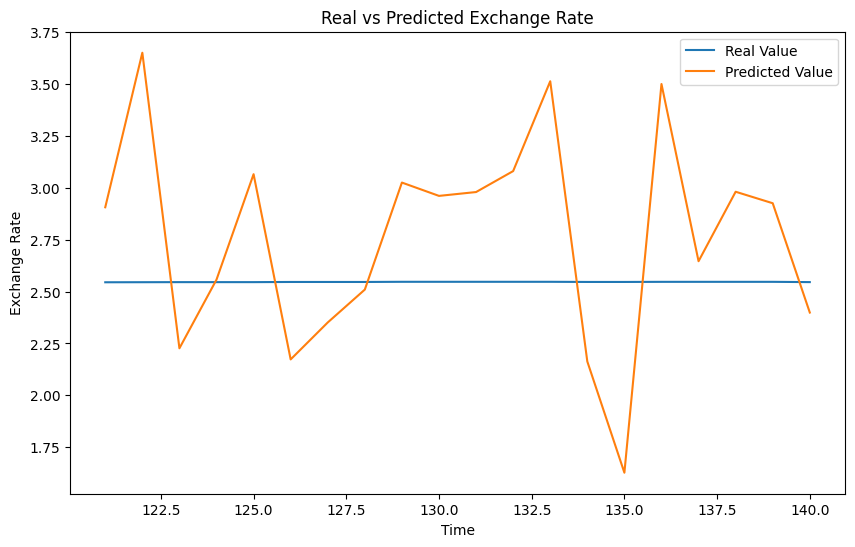

1/1 [==============================] - 0s 62ms/step
prediction [[2.0252552]]
    real_value predicted_value  absolute Error
0     2.546317     [-441477.5]   441480.031250
1     2.546317     [7243.0967]     7240.550293
2     2.545834    [-19825.227]    19827.771484
3     2.547772     [-3798.946]     3801.493896
4     2.547772     [-528.8472]      531.395020
..         ...             ...             ...
137   2.546654       [2.64597]        0.099316
138   2.546654     [2.9805686]        0.433914
139   2.546655     [2.9252176]        0.378562
140   2.545305     [2.3986871]        0.146618
141        NaN     [2.0252552]             NaN

[142 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 87ms/step
prediction [[2.5681374]]
    real_value predicted_value  absolute Error
0     2.546317     [-441477.5]   441480.031250
1     2.546317     [7243.0967]     7240.550293
2     2.545834    [-19825.227]    19827.771484
3     2.547772     [-3798.946]     3801.493896
4     2.547772     [-528.8472]      531.395020
..         ...             ...             ...
138   2.546654     [2.9805686]        0.433914
139   2.546655     [2.9252176]        0.378562
140   2.545305     [2.3986871]        0.146618
141   2.544597     [2.0252552]        0.519341
142        NaN     [2.5681374]             NaN

[143 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 57ms/step
prediction [[1.4634932]]
    real_value predicted_value  absolute Error
0     2.546317     [-441477.5]   441480.031250
1     2.546317     [7243.0967]     7240.550293
2     2.545834    [-19825.227]    19827.771484
3     2.547772     [-3798.946]     3801.493896
4     2.547772     [-528.8472]      531.395020
..         ...             ...             ...
139   2.546655     [2.9252176]        0.378562
140   2.545305     [2.3986871]        0.146618
141   2.544597     [2.0252552]        0.519341
142   2.544597     [2.5681374]        0.023541
143        NaN     [1.4634932]             NaN

[144 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 57ms/step
prediction [[2.9361906]]
    real_value predicted_value  absolute Error
0     2.546317     [-441477.5]   441480.031250
1     2.546317     [7243.0967]     7240.550293
2     2.545834    [-19825.227]    19827.771484
3     2.547772     [-3798.946]     3801.493896
4     2.547772     [-528.8472]      531.395020
..         ...             ...             ...
140   2.545305     [2.3986871]        0.146618
141   2.544597     [2.0252552]        0.519341
142   2.544597     [2.5681374]        0.023541
143   2.544587     [1.4634932]        1.081093
144        NaN     [2.9361906]             NaN

[145 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 55ms/step
prediction [[3.1826272]]
    real_value predicted_value  absolute Error
0     2.546317     [-441477.5]   441480.031250
1     2.546317     [7243.0967]     7240.550293
2     2.545834    [-19825.227]    19827.771484
3     2.547772     [-3798.946]     3801.493896
4     2.547772     [-528.8472]      531.395020
..         ...             ...             ...
141   2.544597     [2.0252552]        0.519341
142   2.544597     [2.5681374]        0.023541
143   2.544587     [1.4634932]        1.081093
144   2.544415     [2.9361906]        0.391776
145        NaN     [3.1826272]             NaN

[146 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 58ms/step
prediction [[2.728352]]
    real_value predicted_value  absolute Error
0     2.546317     [-441477.5]   441480.031250
1     2.546317     [7243.0967]     7240.550293
2     2.545834    [-19825.227]    19827.771484
3     2.547772     [-3798.946]     3801.493896
4     2.547772     [-528.8472]      531.395020
..         ...             ...             ...
142   2.544597     [2.5681374]        0.023541
143   2.544587     [1.4634932]        1.081093
144   2.544415     [2.9361906]        0.391776
145   2.544415     [3.1826272]        0.638213
146        NaN      [2.728352]             NaN

[147 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 52ms/step
prediction [[2.5466528]]
    real_value predicted_value  absolute Error
0     2.546317     [-441477.5]   441480.031250
1     2.546317     [7243.0967]     7240.550293
2     2.545834    [-19825.227]    19827.771484
3     2.547772     [-3798.946]     3801.493896
4     2.547772     [-528.8472]      531.395020
..         ...             ...             ...
143   2.544587     [1.4634932]        1.081093
144   2.544415     [2.9361906]        0.391776
145   2.544415     [3.1826272]        0.638213
146   2.544882      [2.728352]        0.183470
147        NaN     [2.5466528]             NaN

[148 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 56ms/step
prediction [[2.54271]]
    real_value predicted_value  absolute Error
0     2.546317     [-441477.5]   441480.031250
1     2.546317     [7243.0967]     7240.550293
2     2.545834    [-19825.227]    19827.771484
3     2.547772     [-3798.946]     3801.493896
4     2.547772     [-528.8472]      531.395020
..         ...             ...             ...
144   2.544415     [2.9361906]        0.391776
145   2.544415     [3.1826272]        0.638213
146   2.544882      [2.728352]        0.183470
147   2.544464     [2.5466528]        0.002189
148        NaN       [2.54271]             NaN

[149 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 83ms/step
prediction [[1.8147815]]
    real_value predicted_value  absolute Error
0     2.546317     [-441477.5]   441480.031250
1     2.546317     [7243.0967]     7240.550293
2     2.545834    [-19825.227]    19827.771484
3     2.547772     [-3798.946]     3801.493896
4     2.547772     [-528.8472]      531.395020
..         ...             ...             ...
145   2.544415     [3.1826272]        0.638213
146   2.544882      [2.728352]        0.183470
147   2.544464     [2.5466528]        0.002189
148   2.544464       [2.54271]        0.001754
149        NaN     [1.8147815]             NaN

[150 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 97ms/step
prediction [[2.3496153]]
    real_value predicted_value  absolute Error
0     2.546317     [-441477.5]   441480.031250
1     2.546317     [7243.0967]     7240.550293
2     2.545834    [-19825.227]    19827.771484
3     2.547772     [-3798.946]     3801.493896
4     2.547772     [-528.8472]      531.395020
..         ...             ...             ...
146   2.544882      [2.728352]        0.183470
147   2.544464     [2.5466528]        0.002189
148   2.544464       [2.54271]        0.001754
149   2.544187     [1.8147815]        0.729406
150        NaN     [2.3496153]             NaN

[151 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 57ms/step
prediction [[2.486885]]
    real_value predicted_value  absolute Error
0     2.546317     [-441477.5]   441480.031250
1     2.546317     [7243.0967]     7240.550293
2     2.545834    [-19825.227]    19827.771484
3     2.547772     [-3798.946]     3801.493896
4     2.547772     [-528.8472]      531.395020
..         ...             ...             ...
147   2.544464     [2.5466528]        0.002189
148   2.544464       [2.54271]        0.001754
149   2.544187     [1.8147815]        0.729406
150   2.544187     [2.3496153]        0.194572
151        NaN      [2.486885]             NaN

[152 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 85ms/step
prediction [[1.9666245]]
    real_value predicted_value  absolute Error
0     2.546317     [-441477.5]   441480.031250
1     2.546317     [7243.0967]     7240.550293
2     2.545834    [-19825.227]    19827.771484
3     2.547772     [-3798.946]     3801.493896
4     2.547772     [-528.8472]      531.395020
..         ...             ...             ...
148   2.544464       [2.54271]        0.001754
149   2.544187     [1.8147815]        0.729406
150   2.544187     [2.3496153]        0.194572
151   2.543462      [2.486885]        0.056577
152        NaN     [1.9666245]             NaN

[153 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 82ms/step
prediction [[2.6418874]]
    real_value predicted_value  absolute Error
0     2.546317     [-441477.5]   441480.031250
1     2.546317     [7243.0967]     7240.550293
2     2.545834    [-19825.227]    19827.771484
3     2.547772     [-3798.946]     3801.493896
4     2.547772     [-528.8472]      531.395020
..         ...             ...             ...
149   2.544187     [1.8147815]        0.729406
150   2.544187     [2.3496153]        0.194572
151   2.543462      [2.486885]        0.056577
152   2.543044     [1.9666245]        0.576420
153        NaN     [2.6418874]             NaN

[154 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 64ms/step
prediction [[2.3738596]]
    real_value predicted_value  absolute Error
0     2.546317     [-441477.5]   441480.031250
1     2.546317     [7243.0967]     7240.550293
2     2.545834    [-19825.227]    19827.771484
3     2.547772     [-3798.946]     3801.493896
4     2.547772     [-528.8472]      531.395020
..         ...             ...             ...
150   2.544187     [2.3496153]        0.194572
151   2.543462      [2.486885]        0.056577
152   2.543044     [1.9666245]        0.576420
153   2.543044     [2.6418874]        0.098843
154        NaN     [2.3738596]             NaN

[155 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 79ms/step
prediction [[2.0170856]]
    real_value predicted_value  absolute Error
0     2.546317     [-441477.5]   441480.031250
1     2.546317     [7243.0967]     7240.550293
2     2.545834    [-19825.227]    19827.771484
3     2.547772     [-3798.946]     3801.493896
4     2.547772     [-528.8472]      531.395020
..         ...             ...             ...
151   2.543462      [2.486885]        0.056577
152   2.543044     [1.9666245]        0.576420
153   2.543044     [2.6418874]        0.098843
154   2.543043     [2.3738596]        0.169184
155        NaN     [2.0170856]             NaN

[156 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 63ms/step
prediction [[2.9300795]]
    real_value predicted_value  absolute Error
0     2.546317     [-441477.5]   441480.031250
1     2.546317     [7243.0967]     7240.550293
2     2.545834    [-19825.227]    19827.771484
3     2.547772     [-3798.946]     3801.493896
4     2.547772     [-528.8472]      531.395020
..         ...             ...             ...
152   2.543044     [1.9666245]        0.576420
153   2.543044     [2.6418874]        0.098843
154   2.543043     [2.3738596]        0.169184
155   2.542499     [2.0170856]        0.525413
156        NaN     [2.9300795]             NaN

[157 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 59ms/step
prediction [[2.5908852]]
    real_value predicted_value  absolute Error
0     2.546317     [-441477.5]   441480.031250
1     2.546317     [7243.0967]     7240.550293
2     2.545834    [-19825.227]    19827.771484
3     2.547772     [-3798.946]     3801.493896
4     2.547772     [-528.8472]      531.395020
..         ...             ...             ...
153   2.543044     [2.6418874]        0.098843
154   2.543043     [2.3738596]        0.169184
155   2.542499     [2.0170856]        0.525413
156   2.542499     [2.9300795]        0.387581
157        NaN     [2.5908852]             NaN

[158 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 55ms/step
prediction [[3.1799273]]
    real_value predicted_value  absolute Error
0     2.546317     [-441477.5]   441480.031250
1     2.546317     [7243.0967]     7240.550293
2     2.545834    [-19825.227]    19827.771484
3     2.547772     [-3798.946]     3801.493896
4     2.547772     [-528.8472]      531.395020
..         ...             ...             ...
154   2.543043     [2.3738596]        0.169184
155   2.542499     [2.0170856]        0.525413
156   2.542499     [2.9300795]        0.387581
157   2.543349     [2.5908852]        0.047536
158        NaN     [3.1799273]             NaN

[159 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 55ms/step
prediction [[2.9678814]]
    real_value predicted_value  absolute Error
0     2.546317     [-441477.5]   441480.031250
1     2.546317     [7243.0967]     7240.550293
2     2.545834    [-19825.227]    19827.771484
3     2.547772     [-3798.946]     3801.493896
4     2.547772     [-528.8472]      531.395020
..         ...             ...             ...
155   2.542499     [2.0170856]        0.525413
156   2.542499     [2.9300795]        0.387581
157   2.543349     [2.5908852]        0.047536
158   2.541993     [3.1799273]        0.637935
159        NaN     [2.9678814]             NaN

[160 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 77ms/step
prediction [[2.5727015]]
    real_value predicted_value  absolute Error
0     2.546317     [-441477.5]   441480.031250
1     2.546317     [7243.0967]     7240.550293
2     2.545834    [-19825.227]    19827.771484
3     2.547772     [-3798.946]     3801.493896
4     2.547772     [-528.8472]      531.395020
..         ...             ...             ...
156   2.542499     [2.9300795]        0.387581
157   2.543349     [2.5908852]        0.047536
158   2.541993     [3.1799273]        0.637935
159   2.541993     [2.9678814]        0.425889
160        NaN     [2.5727015]             NaN

[161 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 92ms/step
prediction [[3.2778988]]
    real_value predicted_value  absolute Error
0     2.546317     [-441477.5]   441480.031250
1     2.546317     [7243.0967]     7240.550293
2     2.545834    [-19825.227]    19827.771484
3     2.547772     [-3798.946]     3801.493896
4     2.547772     [-528.8472]      531.395020
..         ...             ...             ...
157   2.543349     [2.5908852]        0.047536
158   2.541993     [3.1799273]        0.637935
159   2.541993     [2.9678814]        0.425889
160   2.541993     [2.5727015]        0.030709
161        NaN     [3.2778988]             NaN

[162 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 57ms/step
prediction [[2.4765697]]
    real_value predicted_value  absolute Error
0     2.546317     [-441477.5]   441480.031250
1     2.546317     [7243.0967]     7240.550293
2     2.545834    [-19825.227]    19827.771484
3     2.547772     [-3798.946]     3801.493896
4     2.547772     [-528.8472]      531.395020
..         ...             ...             ...
158   2.541993     [3.1799273]        0.637935
159   2.541993     [2.9678814]        0.425889
160   2.541993     [2.5727015]        0.030709
161   2.542354     [3.2778988]        0.735545
162        NaN     [2.4765697]             NaN

[163 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 54ms/step
prediction [[1.8391656]]
    real_value predicted_value  absolute Error
0     2.546317     [-441477.5]   441480.031250
1     2.546317     [7243.0967]     7240.550293
2     2.545834    [-19825.227]    19827.771484
3     2.547772     [-3798.946]     3801.493896
4     2.547772     [-528.8472]      531.395020
..         ...             ...             ...
159   2.541993     [2.9678814]        0.425889
160   2.541993     [2.5727015]        0.030709
161   2.542354     [3.2778988]        0.735545
162   2.542354     [2.4765697]        0.065784
163        NaN     [1.8391656]             NaN

[164 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 61ms/step
prediction [[2.1772127]]
    real_value predicted_value  absolute Error
0     2.546317     [-441477.5]   441480.031250
1     2.546317     [7243.0967]     7240.550293
2     2.545834    [-19825.227]    19827.771484
3     2.547772     [-3798.946]     3801.493896
4     2.547772     [-528.8472]      531.395020
..         ...             ...             ...
160   2.541993     [2.5727015]        0.030709
161   2.542354     [3.2778988]        0.735545
162   2.542354     [2.4765697]        0.065784
163   2.544503     [1.8391656]        0.705337
164        NaN     [2.1772127]             NaN

[165 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 57ms/step
prediction [[2.095063]]
    real_value predicted_value  absolute Error
0     2.546317     [-441477.5]   441480.031250
1     2.546317     [7243.0967]     7240.550293
2     2.545834    [-19825.227]    19827.771484
3     2.547772     [-3798.946]     3801.493896
4     2.547772     [-528.8472]      531.395020
..         ...             ...             ...
161   2.542354     [3.2778988]        0.735545
162   2.542354     [2.4765697]        0.065784
163   2.544503     [1.8391656]        0.705337
164   2.544503     [2.1772127]        0.367290
165        NaN      [2.095063]             NaN

[166 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 53ms/step
prediction [[2.158626]]
    real_value predicted_value  absolute Error
0     2.546317     [-441477.5]   441480.031250
1     2.546317     [7243.0967]     7240.550293
2     2.545834    [-19825.227]    19827.771484
3     2.547772     [-3798.946]     3801.493896
4     2.547772     [-528.8472]      531.395020
..         ...             ...             ...
162   2.542354     [2.4765697]        0.065784
163   2.544503     [1.8391656]        0.705337
164   2.544503     [2.1772127]        0.367290
165   2.545385      [2.095063]        0.450322
166        NaN      [2.158626]             NaN

[167 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


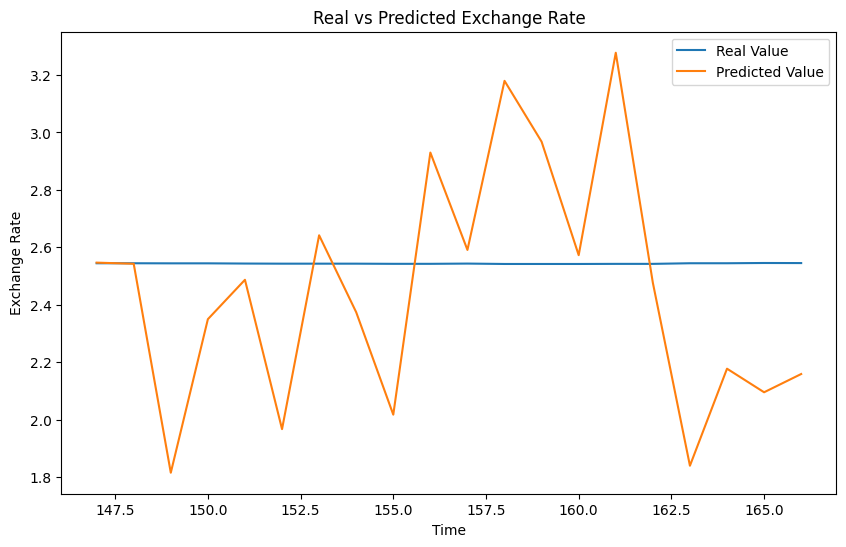

1/1 [==============================] - 0s 55ms/step
prediction [[2.7481046]]
    real_value predicted_value  absolute Error
0     2.546317     [-441477.5]   441480.031250
1     2.546317     [7243.0967]     7240.550293
2     2.545834    [-19825.227]    19827.771484
3     2.547772     [-3798.946]     3801.493896
4     2.547772     [-528.8472]      531.395020
..         ...             ...             ...
163   2.544503     [1.8391656]        0.705337
164   2.544503     [2.1772127]        0.367290
165   2.545385      [2.095063]        0.450322
166   2.545118      [2.158626]        0.386492
167        NaN     [2.7481046]             NaN

[168 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


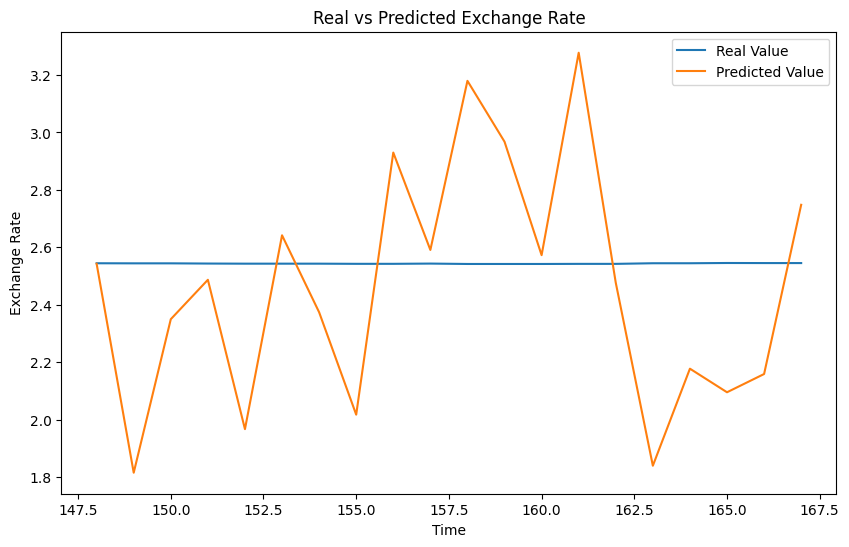

1/1 [==============================] - 0s 84ms/step
prediction [[2.5408711]]
    real_value predicted_value  absolute Error
0     2.546317     [-441477.5]   441480.031250
1     2.546317     [7243.0967]     7240.550293
2     2.545834    [-19825.227]    19827.771484
3     2.547772     [-3798.946]     3801.493896
4     2.547772     [-528.8472]      531.395020
..         ...             ...             ...
164   2.544503     [2.1772127]        0.367290
165   2.545385      [2.095063]        0.450322
166   2.545118      [2.158626]        0.386492
167   2.545118     [2.7481046]        0.202986
168        NaN     [2.5408711]             NaN

[169 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 56ms/step
prediction [[1.9205787]]
    real_value predicted_value  absolute Error
0     2.546317     [-441477.5]   441480.031250
1     2.546317     [7243.0967]     7240.550293
2     2.545834    [-19825.227]    19827.771484
3     2.547772     [-3798.946]     3801.493896
4     2.547772     [-528.8472]      531.395020
..         ...             ...             ...
165   2.545385      [2.095063]        0.450322
166   2.545118      [2.158626]        0.386492
167   2.545118     [2.7481046]        0.202986
168   2.545119     [2.5408711]        0.004248
169        NaN     [1.9205787]             NaN

[170 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 54ms/step
prediction [[2.3608415]]
    real_value predicted_value  absolute Error
0     2.546317     [-441477.5]   441480.031250
1     2.546317     [7243.0967]     7240.550293
2     2.545834    [-19825.227]    19827.771484
3     2.547772     [-3798.946]     3801.493896
4     2.547772     [-528.8472]      531.395020
..         ...             ...             ...
166   2.545118      [2.158626]        0.386492
167   2.545118     [2.7481046]        0.202986
168   2.545119     [2.5408711]        0.004248
169   2.544619     [1.9205787]        0.624040
170        NaN     [2.3608415]             NaN

[171 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 57ms/step
prediction [[2.4288235]]
    real_value predicted_value  absolute Error
0     2.546317     [-441477.5]   441480.031250
1     2.546317     [7243.0967]     7240.550293
2     2.545834    [-19825.227]    19827.771484
3     2.547772     [-3798.946]     3801.493896
4     2.547772     [-528.8472]      531.395020
..         ...             ...             ...
167   2.545118     [2.7481046]        0.202986
168   2.545119     [2.5408711]        0.004248
169   2.544619     [1.9205787]        0.624040
170   2.544619     [2.3608415]        0.183777
171        NaN     [2.4288235]             NaN

[172 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 57ms/step
prediction [[2.8340843]]
    real_value predicted_value  absolute Error
0     2.546317     [-441477.5]   441480.031250
1     2.546317     [7243.0967]     7240.550293
2     2.545834    [-19825.227]    19827.771484
3     2.547772     [-3798.946]     3801.493896
4     2.547772     [-528.8472]      531.395020
..         ...             ...             ...
168   2.545119     [2.5408711]        0.004248
169   2.544619     [1.9205787]        0.624040
170   2.544619     [2.3608415]        0.183777
171   2.544619     [2.4288235]        0.115795
172        NaN     [2.8340843]             NaN

[173 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 55ms/step
prediction [[2.6884463]]
    real_value predicted_value  absolute Error
0     2.546317     [-441477.5]   441480.031250
1     2.546317     [7243.0967]     7240.550293
2     2.545834    [-19825.227]    19827.771484
3     2.547772     [-3798.946]     3801.493896
4     2.547772     [-528.8472]      531.395020
..         ...             ...             ...
169   2.544619     [1.9205787]        0.624040
170   2.544619     [2.3608415]        0.183777
171   2.544619     [2.4288235]        0.115795
172   2.544619     [2.8340843]        0.289465
173        NaN     [2.6884463]             NaN

[174 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 56ms/step
prediction [[2.4510813]]
    real_value predicted_value  absolute Error
0     2.546317     [-441477.5]   441480.031250
1     2.546317     [7243.0967]     7240.550293
2     2.545834    [-19825.227]    19827.771484
3     2.547772     [-3798.946]     3801.493896
4     2.547772     [-528.8472]      531.395020
..         ...             ...             ...
170   2.544619     [2.3608415]        0.183777
171   2.544619     [2.4288235]        0.115795
172   2.544619     [2.8340843]        0.289465
173   2.544619     [2.6884463]        0.143827
174        NaN     [2.4510813]             NaN

[175 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 90ms/step
prediction [[2.4938912]]
    real_value predicted_value  absolute Error
0     2.546317     [-441477.5]   441480.031250
1     2.546317     [7243.0967]     7240.550293
2     2.545834    [-19825.227]    19827.771484
3     2.547772     [-3798.946]     3801.493896
4     2.547772     [-528.8472]      531.395020
..         ...             ...             ...
171   2.544619     [2.4288235]        0.115795
172   2.544619     [2.8340843]        0.289465
173   2.544619     [2.6884463]        0.143827
174    2.54462     [2.4510813]        0.093538
175        NaN     [2.4938912]             NaN

[176 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 62ms/step
prediction [[2.9109592]]
    real_value predicted_value  absolute Error
0     2.546317     [-441477.5]   441480.031250
1     2.546317     [7243.0967]     7240.550293
2     2.545834    [-19825.227]    19827.771484
3     2.547772     [-3798.946]     3801.493896
4     2.547772     [-528.8472]      531.395020
..         ...             ...             ...
172   2.544619     [2.8340843]        0.289465
173   2.544619     [2.6884463]        0.143827
174    2.54462     [2.4510813]        0.093538
175    2.54462     [2.4938912]        0.050728
176        NaN     [2.9109592]             NaN

[177 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 55ms/step
prediction [[2.404842]]
    real_value predicted_value  absolute Error
0     2.546317     [-441477.5]   441480.031250
1     2.546317     [7243.0967]     7240.550293
2     2.545834    [-19825.227]    19827.771484
3     2.547772     [-3798.946]     3801.493896
4     2.547772     [-528.8472]      531.395020
..         ...             ...             ...
173   2.544619     [2.6884463]        0.143827
174    2.54462     [2.4510813]        0.093538
175    2.54462     [2.4938912]        0.050728
176   2.544885     [2.9109592]        0.366074
177        NaN      [2.404842]             NaN

[178 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 52ms/step
prediction [[2.6339886]]
    real_value predicted_value  absolute Error
0     2.546317     [-441477.5]   441480.031250
1     2.546317     [7243.0967]     7240.550293
2     2.545834    [-19825.227]    19827.771484
3     2.547772     [-3798.946]     3801.493896
4     2.547772     [-528.8472]      531.395020
..         ...             ...             ...
174    2.54462     [2.4510813]        0.093538
175    2.54462     [2.4938912]        0.050728
176   2.544885     [2.9109592]        0.366074
177   2.544886      [2.404842]        0.140044
178        NaN     [2.6339886]             NaN

[179 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 54ms/step
prediction [[2.5497115]]
    real_value predicted_value  absolute Error
0     2.546317     [-441477.5]   441480.031250
1     2.546317     [7243.0967]     7240.550293
2     2.545834    [-19825.227]    19827.771484
3     2.547772     [-3798.946]     3801.493896
4     2.547772     [-528.8472]      531.395020
..         ...             ...             ...
175    2.54462     [2.4938912]        0.050728
176   2.544885     [2.9109592]        0.366074
177   2.544886      [2.404842]        0.140044
178   2.544886     [2.6339886]        0.089103
179        NaN     [2.5497115]             NaN

[180 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 57ms/step
prediction [[2.5098498]]
    real_value predicted_value  absolute Error
0     2.546317     [-441477.5]   441480.031250
1     2.546317     [7243.0967]     7240.550293
2     2.545834    [-19825.227]    19827.771484
3     2.547772     [-3798.946]     3801.493896
4     2.547772     [-528.8472]      531.395020
..         ...             ...             ...
176   2.544885     [2.9109592]        0.366074
177   2.544886      [2.404842]        0.140044
178   2.544886     [2.6339886]        0.089103
179   2.545013     [2.5497115]        0.004698
180        NaN     [2.5098498]             NaN

[181 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 89ms/step
prediction [[2.5268247]]
    real_value predicted_value  absolute Error
0     2.546317     [-441477.5]   441480.031250
1     2.546317     [7243.0967]     7240.550293
2     2.545834    [-19825.227]    19827.771484
3     2.547772     [-3798.946]     3801.493896
4     2.547772     [-528.8472]      531.395020
..         ...             ...             ...
177   2.544886      [2.404842]        0.140044
178   2.544886     [2.6339886]        0.089103
179   2.545013     [2.5497115]        0.004698
180   2.545013     [2.5098498]        0.035163
181        NaN     [2.5268247]             NaN

[182 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 54ms/step
prediction [[2.6890724]]
    real_value predicted_value  absolute Error
0     2.546317     [-441477.5]   441480.031250
1     2.546317     [7243.0967]     7240.550293
2     2.545834    [-19825.227]    19827.771484
3     2.547772     [-3798.946]     3801.493896
4     2.547772     [-528.8472]      531.395020
..         ...             ...             ...
178   2.544886     [2.6339886]        0.089103
179   2.545013     [2.5497115]        0.004698
180   2.545013     [2.5098498]        0.035163
181   2.544688     [2.5268247]        0.017864
182        NaN     [2.6890724]             NaN

[183 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 81ms/step
prediction [[2.647217]]
    real_value predicted_value  absolute Error
0     2.546317     [-441477.5]   441480.031250
1     2.546317     [7243.0967]     7240.550293
2     2.545834    [-19825.227]    19827.771484
3     2.547772     [-3798.946]     3801.493896
4     2.547772     [-528.8472]      531.395020
..         ...             ...             ...
179   2.545013     [2.5497115]        0.004698
180   2.545013     [2.5098498]        0.035163
181   2.544688     [2.5268247]        0.017864
182    2.54239     [2.6890724]        0.146683
183        NaN      [2.647217]             NaN

[184 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 54ms/step
prediction [[2.7591157]]
    real_value predicted_value  absolute Error
0     2.546317     [-441477.5]   441480.031250
1     2.546317     [7243.0967]     7240.550293
2     2.545834    [-19825.227]    19827.771484
3     2.547772     [-3798.946]     3801.493896
4     2.547772     [-528.8472]      531.395020
..         ...             ...             ...
180   2.545013     [2.5098498]        0.035163
181   2.544688     [2.5268247]        0.017864
182    2.54239     [2.6890724]        0.146683
183    2.54239      [2.647217]        0.104827
184        NaN     [2.7591157]             NaN

[185 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


Error fetching forex exchange details: could not convert string to float: '-'
1/1 [==============================] - 0s 82ms/step
prediction [[2.5371137]]
    real_value predicted_value  absolute Error
0     2.546317     [-441477.5]   441480.031250
1     2.546317     [7243.0967]     7240.550293
2     2.545834    [-19825.227]    19827.771484
3     2.547772     [-3798.946]     3801.493896
4     2.547772     [-528.8472]      531.395020
..         ...             ...             ...
181   2.544688     [2.5268247]        0.017864
182    2.54239     [2.6890724]        0.146683
183    2.54239      [2.647217]        0.104827
184   2.544851     [2.7591157]        0.214265
185        NaN     [2.5371137]             NaN

[186 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 54ms/step
prediction [[2.1741428]]
    real_value predicted_value  absolute Error
0     2.546317     [-441477.5]   441480.031250
1     2.546317     [7243.0967]     7240.550293
2     2.545834    [-19825.227]    19827.771484
3     2.547772     [-3798.946]     3801.493896
4     2.547772     [-528.8472]      531.395020
..         ...             ...             ...
182    2.54239     [2.6890724]        0.146683
183    2.54239      [2.647217]        0.104827
184   2.544851     [2.7591157]        0.214265
185   2.545339     [2.5371137]        0.008225
186        NaN     [2.1741428]             NaN

[187 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


Error fetching forex exchange details: could not convert string to float: '-'
1/1 [==============================] - 0s 58ms/step
prediction [[2.5340803]]
    real_value predicted_value  absolute Error
0     2.546317     [-441477.5]   441480.031250
1     2.546317     [7243.0967]     7240.550293
2     2.545834    [-19825.227]    19827.771484
3     2.547772     [-3798.946]     3801.493896
4     2.547772     [-528.8472]      531.395020
..         ...             ...             ...
183    2.54239      [2.647217]        0.104827
184   2.544851     [2.7591157]        0.214265
185   2.545339     [2.5371137]        0.008225
186   2.545865     [2.1741428]        0.371722
187        NaN     [2.5340803]             NaN

[188 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 56ms/step
prediction [[2.45657]]
    real_value predicted_value  absolute Error
0     2.546317     [-441477.5]   441480.031250
1     2.546317     [7243.0967]     7240.550293
2     2.545834    [-19825.227]    19827.771484
3     2.547772     [-3798.946]     3801.493896
4     2.547772     [-528.8472]      531.395020
..         ...             ...             ...
184   2.544851     [2.7591157]        0.214265
185   2.545339     [2.5371137]        0.008225
186   2.545865     [2.1741428]        0.371722
187   2.545865     [2.5340803]        0.011785
188        NaN       [2.45657]             NaN

[189 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 56ms/step
prediction [[2.4747858]]
    real_value predicted_value  absolute Error
0     2.546317     [-441477.5]   441480.031250
1     2.546317     [7243.0967]     7240.550293
2     2.545834    [-19825.227]    19827.771484
3     2.547772     [-3798.946]     3801.493896
4     2.547772     [-528.8472]      531.395020
..         ...             ...             ...
185   2.545339     [2.5371137]        0.008225
186   2.545865     [2.1741428]        0.371722
187   2.545865     [2.5340803]        0.011785
188   2.545992       [2.45657]        0.089422
189        NaN     [2.4747858]             NaN

[190 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 82ms/step
prediction [[2.7928982]]
    real_value predicted_value  absolute Error
0     2.546317     [-441477.5]   441480.031250
1     2.546317     [7243.0967]     7240.550293
2     2.545834    [-19825.227]    19827.771484
3     2.547772     [-3798.946]     3801.493896
4     2.547772     [-528.8472]      531.395020
..         ...             ...             ...
186   2.545865     [2.1741428]        0.371722
187   2.545865     [2.5340803]        0.011785
188   2.545992       [2.45657]        0.089422
189   2.545992     [2.4747858]        0.071207
190        NaN     [2.7928982]             NaN

[191 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 77ms/step
prediction [[2.544151]]
    real_value predicted_value  absolute Error
0     2.546317     [-441477.5]   441480.031250
1     2.546317     [7243.0967]     7240.550293
2     2.545834    [-19825.227]    19827.771484
3     2.547772     [-3798.946]     3801.493896
4     2.547772     [-528.8472]      531.395020
..         ...             ...             ...
187   2.545865     [2.5340803]        0.011785
188   2.545992       [2.45657]        0.089422
189   2.545992     [2.4747858]        0.071207
190   2.545208     [2.7928982]        0.247690
191        NaN      [2.544151]             NaN

[192 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 52ms/step
prediction [[2.573586]]
    real_value predicted_value  absolute Error
0     2.546317     [-441477.5]   441480.031250
1     2.546317     [7243.0967]     7240.550293
2     2.545834    [-19825.227]    19827.771484
3     2.547772     [-3798.946]     3801.493896
4     2.547772     [-528.8472]      531.395020
..         ...             ...             ...
188   2.545992       [2.45657]        0.089422
189   2.545992     [2.4747858]        0.071207
190   2.545208     [2.7928982]        0.247690
191   2.545208      [2.544151]        0.001057
192        NaN      [2.573586]             NaN

[193 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 56ms/step
prediction [[2.5918827]]
    real_value predicted_value  absolute Error
0     2.546317     [-441477.5]   441480.031250
1     2.546317     [7243.0967]     7240.550293
2     2.545834    [-19825.227]    19827.771484
3     2.547772     [-3798.946]     3801.493896
4     2.547772     [-528.8472]      531.395020
..         ...             ...             ...
189   2.545992     [2.4747858]        0.071207
190   2.545208     [2.7928982]        0.247690
191   2.545208      [2.544151]        0.001057
192   2.544583      [2.573586]        0.029003
193        NaN     [2.5918827]             NaN

[194 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 59ms/step
prediction [[2.5753345]]
    real_value predicted_value  absolute Error
0     2.546317     [-441477.5]   441480.031250
1     2.546317     [7243.0967]     7240.550293
2     2.545834    [-19825.227]    19827.771484
3     2.547772     [-3798.946]     3801.493896
4     2.547772     [-528.8472]      531.395020
..         ...             ...             ...
190   2.545208     [2.7928982]        0.247690
191   2.545208      [2.544151]        0.001057
192   2.544583      [2.573586]        0.029003
193   2.545835     [2.5918827]        0.046048
194        NaN     [2.5753345]             NaN

[195 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 54ms/step
prediction [[2.664442]]
    real_value predicted_value  absolute Error
0     2.546317     [-441477.5]   441480.031250
1     2.546317     [7243.0967]     7240.550293
2     2.545834    [-19825.227]    19827.771484
3     2.547772     [-3798.946]     3801.493896
4     2.547772     [-528.8472]      531.395020
..         ...             ...             ...
191   2.545208      [2.544151]        0.001057
192   2.544583      [2.573586]        0.029003
193   2.545835     [2.5918827]        0.046048
194   2.545835     [2.5753345]        0.029500
195        NaN      [2.664442]             NaN

[196 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


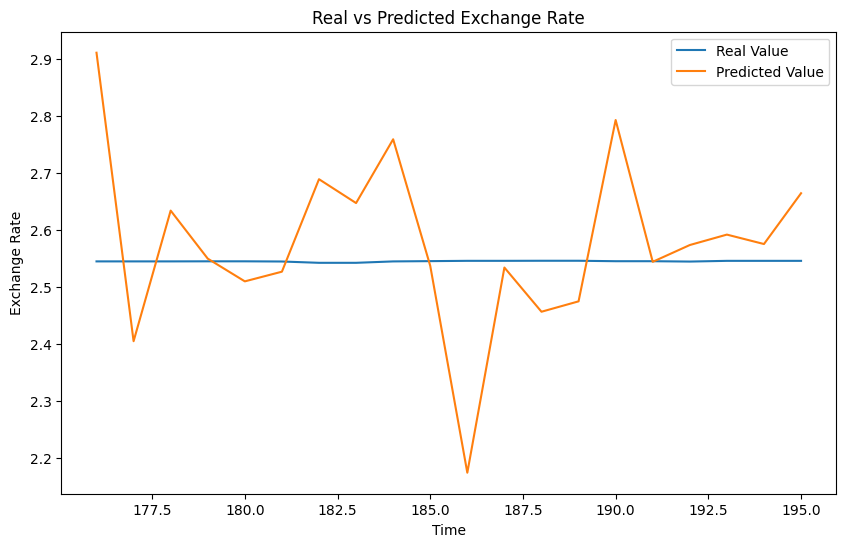

1/1 [==============================] - 0s 57ms/step
prediction [[2.203273]]
    real_value predicted_value  absolute Error
0     2.546317     [-441477.5]   441480.031250
1     2.546317     [7243.0967]     7240.550293
2     2.545834    [-19825.227]    19827.771484
3     2.547772     [-3798.946]     3801.493896
4     2.547772     [-528.8472]      531.395020
..         ...             ...             ...
192   2.544583      [2.573586]        0.029003
193   2.545835     [2.5918827]        0.046048
194   2.545835     [2.5753345]        0.029500
195   2.545833      [2.664442]        0.118609
196        NaN      [2.203273]             NaN

[197 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 83ms/step
prediction [[2.4793148]]
    real_value predicted_value  absolute Error
0     2.546317     [-441477.5]   441480.031250
1     2.546317     [7243.0967]     7240.550293
2     2.545834    [-19825.227]    19827.771484
3     2.547772     [-3798.946]     3801.493896
4     2.547772     [-528.8472]      531.395020
..         ...             ...             ...
193   2.545835     [2.5918827]        0.046048
194   2.545835     [2.5753345]        0.029500
195   2.545833      [2.664442]        0.118609
196   2.546686      [2.203273]        0.343413
197        NaN     [2.4793148]             NaN

[198 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 51ms/step
prediction [[2.5459409]]
    real_value predicted_value  absolute Error
0     2.546317     [-441477.5]   441480.031250
1     2.546317     [7243.0967]     7240.550293
2     2.545834    [-19825.227]    19827.771484
3     2.547772     [-3798.946]     3801.493896
4     2.547772     [-528.8472]      531.395020
..         ...             ...             ...
194   2.545835     [2.5753345]        0.029500
195   2.545833      [2.664442]        0.118609
196   2.546686      [2.203273]        0.343413
197   2.546686     [2.4793148]        0.067371
198        NaN     [2.5459409]             NaN

[199 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 58ms/step
prediction [[2.4837878]]
    real_value predicted_value  absolute Error
0     2.546317     [-441477.5]   441480.031250
1     2.546317     [7243.0967]     7240.550293
2     2.545834    [-19825.227]    19827.771484
3     2.547772     [-3798.946]     3801.493896
4     2.547772     [-528.8472]      531.395020
..         ...             ...             ...
195   2.545833      [2.664442]        0.118609
196   2.546686      [2.203273]        0.343413
197   2.546686     [2.4793148]        0.067371
198   2.546591     [2.5459409]        0.000650
199        NaN     [2.4837878]             NaN

[200 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 51ms/step
prediction [[2.3765895]]
    real_value predicted_value  absolute Error
0     2.546317     [-441477.5]   441480.031250
1     2.546317     [7243.0967]     7240.550293
2     2.545834    [-19825.227]    19827.771484
3     2.547772     [-3798.946]     3801.493896
4     2.547772     [-528.8472]      531.395020
..         ...             ...             ...
196   2.546686      [2.203273]        0.343413
197   2.546686     [2.4793148]        0.067371
198   2.546591     [2.5459409]        0.000650
199   2.546591     [2.4837878]        0.062803
200        NaN     [2.3765895]             NaN

[201 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 55ms/step
prediction [[2.5996888]]
    real_value predicted_value  absolute Error
0     2.546317     [-441477.5]   441480.031250
1     2.546317     [7243.0967]     7240.550293
2     2.545834    [-19825.227]    19827.771484
3     2.547772     [-3798.946]     3801.493896
4     2.547772     [-528.8472]      531.395020
..         ...             ...             ...
197   2.546686     [2.4793148]        0.067371
198   2.546591     [2.5459409]        0.000650
199   2.546591     [2.4837878]        0.062803
200   2.546687     [2.3765895]        0.170098
201        NaN     [2.5996888]             NaN

[202 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 54ms/step
prediction [[2.5025215]]
    real_value predicted_value  absolute Error
0     2.546317     [-441477.5]   441480.031250
1     2.546317     [7243.0967]     7240.550293
2     2.545834    [-19825.227]    19827.771484
3     2.547772     [-3798.946]     3801.493896
4     2.547772     [-528.8472]      531.395020
..         ...             ...             ...
198   2.546591     [2.5459409]        0.000650
199   2.546591     [2.4837878]        0.062803
200   2.546687     [2.3765895]        0.170098
201   2.545508     [2.5996888]        0.054181
202        NaN     [2.5025215]             NaN

[203 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 51ms/step
prediction [[2.3659153]]
    real_value predicted_value  absolute Error
0     2.546317     [-441477.5]   441480.031250
1     2.546317     [7243.0967]     7240.550293
2     2.545834    [-19825.227]    19827.771484
3     2.547772     [-3798.946]     3801.493896
4     2.547772     [-528.8472]      531.395020
..         ...             ...             ...
199   2.546591     [2.4837878]        0.062803
200   2.546687     [2.3765895]        0.170098
201   2.545508     [2.5996888]        0.054181
202   2.545508     [2.5025215]        0.042986
203        NaN     [2.3659153]             NaN

[204 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 54ms/step
prediction [[2.4344032]]
    real_value predicted_value  absolute Error
0     2.546317     [-441477.5]   441480.031250
1     2.546317     [7243.0967]     7240.550293
2     2.545834    [-19825.227]    19827.771484
3     2.547772     [-3798.946]     3801.493896
4     2.547772     [-528.8472]      531.395020
..         ...             ...             ...
200   2.546687     [2.3765895]        0.170098
201   2.545508     [2.5996888]        0.054181
202   2.545508     [2.5025215]        0.042986
203   2.545632     [2.3659153]        0.179716
204        NaN     [2.4344032]             NaN

[205 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 63ms/step
prediction [[2.5427437]]
    real_value predicted_value  absolute Error
0     2.546317     [-441477.5]   441480.031250
1     2.546317     [7243.0967]     7240.550293
2     2.545834    [-19825.227]    19827.771484
3     2.547772     [-3798.946]     3801.493896
4     2.547772     [-528.8472]      531.395020
..         ...             ...             ...
201   2.545508     [2.5996888]        0.054181
202   2.545508     [2.5025215]        0.042986
203   2.545632     [2.3659153]        0.179716
204   2.544736     [2.4344032]        0.110333
205        NaN     [2.5427437]             NaN

[206 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 89ms/step
prediction [[2.5061283]]
    real_value predicted_value  absolute Error
0     2.546317     [-441477.5]   441480.031250
1     2.546317     [7243.0967]     7240.550293
2     2.545834    [-19825.227]    19827.771484
3     2.547772     [-3798.946]     3801.493896
4     2.547772     [-528.8472]      531.395020
..         ...             ...             ...
202   2.545508     [2.5025215]        0.042986
203   2.545632     [2.3659153]        0.179716
204   2.544736     [2.4344032]        0.110333
205   2.544736     [2.5427437]        0.001992
206        NaN     [2.5061283]             NaN

[207 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 77ms/step
prediction [[2.6659863]]
    real_value predicted_value  absolute Error
0     2.546317     [-441477.5]   441480.031250
1     2.546317     [7243.0967]     7240.550293
2     2.545834    [-19825.227]    19827.771484
3     2.547772     [-3798.946]     3801.493896
4     2.547772     [-528.8472]      531.395020
..         ...             ...             ...
203   2.545632     [2.3659153]        0.179716
204   2.544736     [2.4344032]        0.110333
205   2.544736     [2.5427437]        0.001992
206   2.544735     [2.5061283]        0.038607
207        NaN     [2.6659863]             NaN

[208 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 55ms/step
prediction [[2.2306845]]
    real_value predicted_value  absolute Error
0     2.546317     [-441477.5]   441480.031250
1     2.546317     [7243.0967]     7240.550293
2     2.545834    [-19825.227]    19827.771484
3     2.547772     [-3798.946]     3801.493896
4     2.547772     [-528.8472]      531.395020
..         ...             ...             ...
204   2.544736     [2.4344032]        0.110333
205   2.544736     [2.5427437]        0.001992
206   2.544735     [2.5061283]        0.038607
207   2.544735     [2.6659863]        0.121251
208        NaN     [2.2306845]             NaN

[209 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 51ms/step
prediction [[2.9247446]]
    real_value predicted_value  absolute Error
0     2.546317     [-441477.5]   441480.031250
1     2.546317     [7243.0967]     7240.550293
2     2.545834    [-19825.227]    19827.771484
3     2.547772     [-3798.946]     3801.493896
4     2.547772     [-528.8472]      531.395020
..         ...             ...             ...
205   2.544736     [2.5427437]        0.001992
206   2.544735     [2.5061283]        0.038607
207   2.544735     [2.6659863]        0.121251
208   2.544741     [2.2306845]        0.314056
209        NaN     [2.9247446]             NaN

[210 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 55ms/step
prediction [[2.622424]]
    real_value predicted_value  absolute Error
0     2.546317     [-441477.5]   441480.031250
1     2.546317     [7243.0967]     7240.550293
2     2.545834    [-19825.227]    19827.771484
3     2.547772     [-3798.946]     3801.493896
4     2.547772     [-528.8472]      531.395020
..         ...             ...             ...
206   2.544735     [2.5061283]        0.038607
207   2.544735     [2.6659863]        0.121251
208   2.544741     [2.2306845]        0.314056
209   2.544741     [2.9247446]        0.380004
210        NaN      [2.622424]             NaN

[211 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 61ms/step
prediction [[2.6007876]]
    real_value predicted_value  absolute Error
0     2.546317     [-441477.5]   441480.031250
1     2.546317     [7243.0967]     7240.550293
2     2.545834    [-19825.227]    19827.771484
3     2.547772     [-3798.946]     3801.493896
4     2.547772     [-528.8472]      531.395020
..         ...             ...             ...
207   2.544735     [2.6659863]        0.121251
208   2.544741     [2.2306845]        0.314056
209   2.544741     [2.9247446]        0.380004
210   2.544741      [2.622424]        0.077683
211        NaN     [2.6007876]             NaN

[212 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


Error fetching forex exchange details: could not convert string to float: '-'
1/1 [==============================] - 0s 53ms/step
prediction [[2.5150666]]
    real_value predicted_value  absolute Error
0     2.546317     [-441477.5]   441480.031250
1     2.546317     [7243.0967]     7240.550293
2     2.545834    [-19825.227]    19827.771484
3     2.547772     [-3798.946]     3801.493896
4     2.547772     [-528.8472]      531.395020
..         ...             ...             ...
208   2.544741     [2.2306845]        0.314056
209   2.544741     [2.9247446]        0.380004
210   2.544741      [2.622424]        0.077683
211   2.544396     [2.6007876]        0.056391
212        NaN     [2.5150666]             NaN

[213 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 61ms/step
prediction [[2.583057]]
    real_value predicted_value  absolute Error
0     2.546317     [-441477.5]   441480.031250
1     2.546317     [7243.0967]     7240.550293
2     2.545834    [-19825.227]    19827.771484
3     2.547772     [-3798.946]     3801.493896
4     2.547772     [-528.8472]      531.395020
..         ...             ...             ...
209   2.544741     [2.9247446]        0.380004
210   2.544741      [2.622424]        0.077683
211   2.544396     [2.6007876]        0.056391
212   2.543327     [2.5150666]        0.028260
213        NaN      [2.583057]             NaN

[214 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 55ms/step
prediction [[2.4539149]]
    real_value predicted_value  absolute Error
0     2.546317     [-441477.5]   441480.031250
1     2.546317     [7243.0967]     7240.550293
2     2.545834    [-19825.227]    19827.771484
3     2.547772     [-3798.946]     3801.493896
4     2.547772     [-528.8472]      531.395020
..         ...             ...             ...
210   2.544741      [2.622424]        0.077683
211   2.544396     [2.6007876]        0.056391
212   2.543327     [2.5150666]        0.028260
213   2.543133      [2.583057]        0.039924
214        NaN     [2.4539149]             NaN

[215 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 86ms/step
prediction [[2.6175008]]
    real_value predicted_value  absolute Error
0     2.546317     [-441477.5]   441480.031250
1     2.546317     [7243.0967]     7240.550293
2     2.545834    [-19825.227]    19827.771484
3     2.547772     [-3798.946]     3801.493896
4     2.547772     [-528.8472]      531.395020
..         ...             ...             ...
211   2.544396     [2.6007876]        0.056391
212   2.543327     [2.5150666]        0.028260
213   2.543133      [2.583057]        0.039924
214   2.543133     [2.4539149]        0.089218
215        NaN     [2.6175008]             NaN

[216 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 55ms/step
prediction [[2.571198]]
    real_value predicted_value  absolute Error
0     2.546317     [-441477.5]   441480.031250
1     2.546317     [7243.0967]     7240.550293
2     2.545834    [-19825.227]    19827.771484
3     2.547772     [-3798.946]     3801.493896
4     2.547772     [-528.8472]      531.395020
..         ...             ...             ...
212   2.543327     [2.5150666]        0.028260
213   2.543133      [2.583057]        0.039924
214   2.543133     [2.4539149]        0.089218
215   2.541681     [2.6175008]        0.075820
216        NaN      [2.571198]             NaN

[217 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 54ms/step
prediction [[2.6029203]]
    real_value predicted_value  absolute Error
0     2.546317     [-441477.5]   441480.031250
1     2.546317     [7243.0967]     7240.550293
2     2.545834    [-19825.227]    19827.771484
3     2.547772     [-3798.946]     3801.493896
4     2.547772     [-528.8472]      531.395020
..         ...             ...             ...
213   2.543133      [2.583057]        0.039924
214   2.543133     [2.4539149]        0.089218
215   2.541681     [2.6175008]        0.075820
216   2.542071      [2.571198]        0.029127
217        NaN     [2.6029203]             NaN

[218 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 57ms/step
prediction [[2.620513]]
    real_value predicted_value  absolute Error
0     2.546317     [-441477.5]   441480.031250
1     2.546317     [7243.0967]     7240.550293
2     2.545834    [-19825.227]    19827.771484
3     2.547772     [-3798.946]     3801.493896
4     2.547772     [-528.8472]      531.395020
..         ...             ...             ...
214   2.543133     [2.4539149]        0.089218
215   2.541681     [2.6175008]        0.075820
216   2.542071      [2.571198]        0.029127
217   2.542071     [2.6029203]        0.060849
218        NaN      [2.620513]             NaN

[219 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 52ms/step
prediction [[2.5076494]]
    real_value predicted_value  absolute Error
0     2.546317     [-441477.5]   441480.031250
1     2.546317     [7243.0967]     7240.550293
2     2.545834    [-19825.227]    19827.771484
3     2.547772     [-3798.946]     3801.493896
4     2.547772     [-528.8472]      531.395020
..         ...             ...             ...
215   2.541681     [2.6175008]        0.075820
216   2.542071      [2.571198]        0.029127
217   2.542071     [2.6029203]        0.060849
218   2.542915      [2.620513]        0.077598
219        NaN     [2.5076494]             NaN

[220 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 65ms/step
prediction [[2.604983]]
    real_value predicted_value  absolute Error
0     2.546317     [-441477.5]   441480.031250
1     2.546317     [7243.0967]     7240.550293
2     2.545834    [-19825.227]    19827.771484
3     2.547772     [-3798.946]     3801.493896
4     2.547772     [-528.8472]      531.395020
..         ...             ...             ...
216   2.542071      [2.571198]        0.029127
217   2.542071     [2.6029203]        0.060849
218   2.542915      [2.620513]        0.077598
219   2.542915     [2.5076494]        0.035266
220        NaN      [2.604983]             NaN

[221 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 51ms/step
prediction [[2.4873874]]
    real_value predicted_value  absolute Error
0     2.546317     [-441477.5]   441480.031250
1     2.546317     [7243.0967]     7240.550293
2     2.545834    [-19825.227]    19827.771484
3     2.547772     [-3798.946]     3801.493896
4     2.547772     [-528.8472]      531.395020
..         ...             ...             ...
217   2.542071     [2.6029203]        0.060849
218   2.542915      [2.620513]        0.077598
219   2.542915     [2.5076494]        0.035266
220   2.542883      [2.604983]        0.062101
221        NaN     [2.4873874]             NaN

[222 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


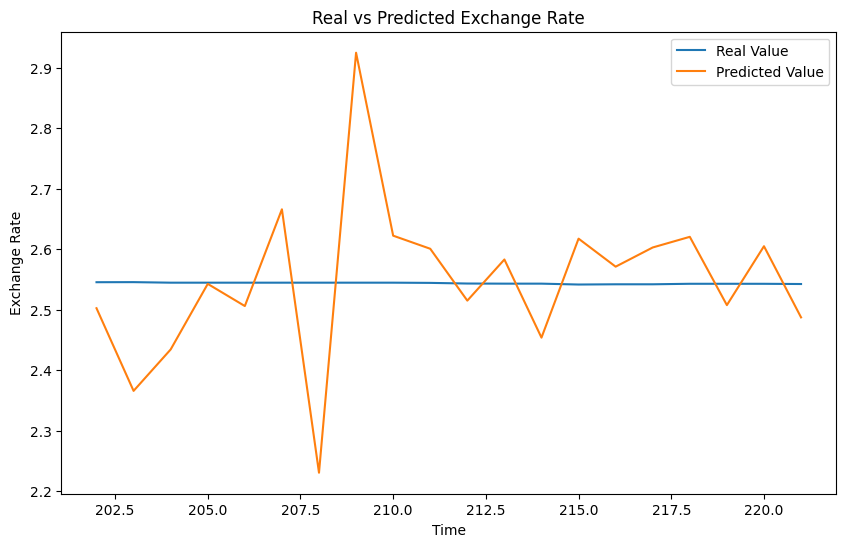

1/1 [==============================] - 0s 80ms/step
prediction [[2.497504]]
    real_value predicted_value  absolute Error
0     2.546317     [-441477.5]   441480.031250
1     2.546317     [7243.0967]     7240.550293
2     2.545834    [-19825.227]    19827.771484
3     2.547772     [-3798.946]     3801.493896
4     2.547772     [-528.8472]      531.395020
..         ...             ...             ...
218   2.542915      [2.620513]        0.077598
219   2.542915     [2.5076494]        0.035266
220   2.542883      [2.604983]        0.062101
221   2.542518     [2.4873874]        0.055131
222        NaN      [2.497504]             NaN

[223 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


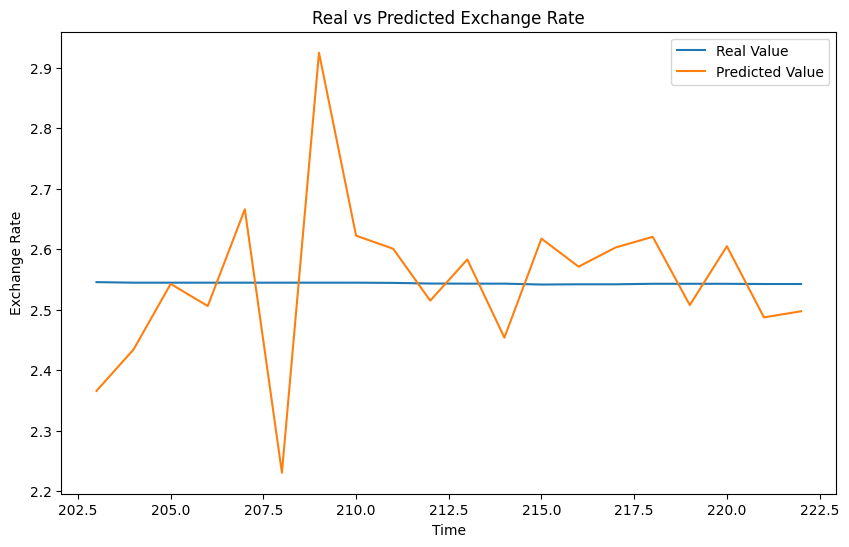

1/1 [==============================] - 0s 55ms/step
prediction [[2.7019901]]
    real_value predicted_value  absolute Error
0     2.546317     [-441477.5]   441480.031250
1     2.546317     [7243.0967]     7240.550293
2     2.545834    [-19825.227]    19827.771484
3     2.547772     [-3798.946]     3801.493896
4     2.547772     [-528.8472]      531.395020
..         ...             ...             ...
219   2.542915     [2.5076494]        0.035266
220   2.542883      [2.604983]        0.062101
221   2.542518     [2.4873874]        0.055131
222   2.542518      [2.497504]        0.045014
223        NaN     [2.7019901]             NaN

[224 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 51ms/step
prediction [[2.5608704]]
    real_value predicted_value  absolute Error
0     2.546317     [-441477.5]   441480.031250
1     2.546317     [7243.0967]     7240.550293
2     2.545834    [-19825.227]    19827.771484
3     2.547772     [-3798.946]     3801.493896
4     2.547772     [-528.8472]      531.395020
..         ...             ...             ...
220   2.542883      [2.604983]        0.062101
221   2.542518     [2.4873874]        0.055131
222   2.542518      [2.497504]        0.045014
223   2.542718     [2.7019901]        0.159272
224        NaN     [2.5608704]             NaN

[225 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 54ms/step
prediction [[3.0887222]]
    real_value predicted_value  absolute Error
0     2.546317     [-441477.5]   441480.031250
1     2.546317     [7243.0967]     7240.550293
2     2.545834    [-19825.227]    19827.771484
3     2.547772     [-3798.946]     3801.493896
4     2.547772     [-528.8472]      531.395020
..         ...             ...             ...
221   2.542518     [2.4873874]        0.055131
222   2.542518      [2.497504]        0.045014
223   2.542718     [2.7019901]        0.159272
224   2.542718     [2.5608704]        0.018153
225        NaN     [3.0887222]             NaN

[226 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 59ms/step
prediction [[2.235124]]
    real_value predicted_value  absolute Error
0     2.546317     [-441477.5]   441480.031250
1     2.546317     [7243.0967]     7240.550293
2     2.545834    [-19825.227]    19827.771484
3     2.547772     [-3798.946]     3801.493896
4     2.547772     [-528.8472]      531.395020
..         ...             ...             ...
222   2.542518      [2.497504]        0.045014
223   2.542718     [2.7019901]        0.159272
224   2.542718     [2.5608704]        0.018153
225   2.542718     [3.0887222]        0.546005
226        NaN      [2.235124]             NaN

[227 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 55ms/step
prediction [[3.742233]]
    real_value predicted_value  absolute Error
0     2.546317     [-441477.5]   441480.031250
1     2.546317     [7243.0967]     7240.550293
2     2.545834    [-19825.227]    19827.771484
3     2.547772     [-3798.946]     3801.493896
4     2.547772     [-528.8472]      531.395020
..         ...             ...             ...
223   2.542718     [2.7019901]        0.159272
224   2.542718     [2.5608704]        0.018153
225   2.542718     [3.0887222]        0.546005
226   2.542718      [2.235124]        0.307594
227        NaN      [3.742233]             NaN

[228 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 101ms/step
prediction [[2.2687404]]
    real_value predicted_value  absolute Error
0     2.546317     [-441477.5]   441480.031250
1     2.546317     [7243.0967]     7240.550293
2     2.545834    [-19825.227]    19827.771484
3     2.547772     [-3798.946]     3801.493896
4     2.547772     [-528.8472]      531.395020
..         ...             ...             ...
224   2.542718     [2.5608704]        0.018153
225   2.542718     [3.0887222]        0.546005
226   2.542718      [2.235124]        0.307594
227   2.542718      [3.742233]        1.199515
228        NaN     [2.2687404]             NaN

[229 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 52ms/step
prediction [[-10.343521]]
    real_value predicted_value  absolute Error
0     2.546317     [-441477.5]   441480.031250
1     2.546317     [7243.0967]     7240.550293
2     2.545834    [-19825.227]    19827.771484
3     2.547772     [-3798.946]     3801.493896
4     2.547772     [-528.8472]      531.395020
..         ...             ...             ...
225   2.542718     [3.0887222]        0.546005
226   2.542718      [2.235124]        0.307594
227   2.542718      [3.742233]        1.199515
228   2.542353     [2.2687404]        0.273612
229        NaN    [-10.343521]             NaN

[230 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 50ms/step
prediction [[2.521213]]
    real_value predicted_value  absolute Error
0     2.546317     [-441477.5]   441480.031250
1     2.546317     [7243.0967]     7240.550293
2     2.545834    [-19825.227]    19827.771484
3     2.547772     [-3798.946]     3801.493896
4     2.547772     [-528.8472]      531.395020
..         ...             ...             ...
226   2.542718      [2.235124]        0.307594
227   2.542718      [3.742233]        1.199515
228   2.542353     [2.2687404]        0.273612
229   2.542504    [-10.343521]       12.886025
230        NaN      [2.521213]             NaN

[231 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 50ms/step
prediction [[2.6427474]]
    real_value predicted_value  absolute Error
0     2.546317     [-441477.5]   441480.031250
1     2.546317     [7243.0967]     7240.550293
2     2.545834    [-19825.227]    19827.771484
3     2.547772     [-3798.946]     3801.493896
4     2.547772     [-528.8472]      531.395020
..         ...             ...             ...
227   2.542718      [3.742233]        1.199515
228   2.542353     [2.2687404]        0.273612
229   2.542504    [-10.343521]       12.886025
230   2.542504      [2.521213]        0.021291
231        NaN     [2.6427474]             NaN

[232 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 53ms/step
prediction [[2.274537]]
    real_value predicted_value  absolute Error
0     2.546317     [-441477.5]   441480.031250
1     2.546317     [7243.0967]     7240.550293
2     2.545834    [-19825.227]    19827.771484
3     2.547772     [-3798.946]     3801.493896
4     2.547772     [-528.8472]      531.395020
..         ...             ...             ...
228   2.542353     [2.2687404]        0.273612
229   2.542504    [-10.343521]       12.886025
230   2.542504      [2.521213]        0.021291
231   2.542505     [2.6427474]        0.100242
232        NaN      [2.274537]             NaN

[233 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 53ms/step
prediction [[2.1987753]]
    real_value predicted_value  absolute Error
0     2.546317     [-441477.5]   441480.031250
1     2.546317     [7243.0967]     7240.550293
2     2.545834    [-19825.227]    19827.771484
3     2.547772     [-3798.946]     3801.493896
4     2.547772     [-528.8472]      531.395020
..         ...             ...             ...
229   2.542504    [-10.343521]       12.886025
230   2.542504      [2.521213]        0.021291
231   2.542505     [2.6427474]        0.100242
232   2.542505      [2.274537]        0.267968
233        NaN     [2.1987753]             NaN

[234 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 51ms/step
prediction [[2.3998415]]
    real_value predicted_value  absolute Error
0     2.546317     [-441477.5]   441480.031250
1     2.546317     [7243.0967]     7240.550293
2     2.545834    [-19825.227]    19827.771484
3     2.547772     [-3798.946]     3801.493896
4     2.547772     [-528.8472]      531.395020
..         ...             ...             ...
230   2.542504      [2.521213]        0.021291
231   2.542505     [2.6427474]        0.100242
232   2.542505      [2.274537]        0.267968
233    2.54157     [2.1987753]        0.342795
234        NaN     [2.3998415]             NaN

[235 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 87ms/step
prediction [[1.7878612]]
    real_value predicted_value  absolute Error
0     2.546317     [-441477.5]   441480.031250
1     2.546317     [7243.0967]     7240.550293
2     2.545834    [-19825.227]    19827.771484
3     2.547772     [-3798.946]     3801.493896
4     2.547772     [-528.8472]      531.395020
..         ...             ...             ...
231   2.542505     [2.6427474]        0.100242
232   2.542505      [2.274537]        0.267968
233    2.54157     [2.1987753]        0.342795
234   2.541217     [2.3998415]        0.141375
235        NaN     [1.7878612]             NaN

[236 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 51ms/step
prediction [[1.7106602]]
    real_value predicted_value  absolute Error
0     2.546317     [-441477.5]   441480.031250
1     2.546317     [7243.0967]     7240.550293
2     2.545834    [-19825.227]    19827.771484
3     2.547772     [-3798.946]     3801.493896
4     2.547772     [-528.8472]      531.395020
..         ...             ...             ...
232   2.542505      [2.274537]        0.267968
233    2.54157     [2.1987753]        0.342795
234   2.541217     [2.3998415]        0.141375
235   2.541217     [1.7878612]        0.753356
236        NaN     [1.7106602]             NaN

[237 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 54ms/step
prediction [[2.2398038]]
    real_value predicted_value  absolute Error
0     2.546317     [-441477.5]   441480.031250
1     2.546317     [7243.0967]     7240.550293
2     2.545834    [-19825.227]    19827.771484
3     2.547772     [-3798.946]     3801.493896
4     2.547772     [-528.8472]      531.395020
..         ...             ...             ...
233    2.54157     [2.1987753]        0.342795
234   2.541217     [2.3998415]        0.141375
235   2.541217     [1.7878612]        0.753356
236   2.542728     [1.7106602]        0.832067
237        NaN     [2.2398038]             NaN

[238 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 52ms/step
prediction [[2.4809966]]
    real_value predicted_value  absolute Error
0     2.546317     [-441477.5]   441480.031250
1     2.546317     [7243.0967]     7240.550293
2     2.545834    [-19825.227]    19827.771484
3     2.547772     [-3798.946]     3801.493896
4     2.547772     [-528.8472]      531.395020
..         ...             ...             ...
234   2.541217     [2.3998415]        0.141375
235   2.541217     [1.7878612]        0.753356
236   2.542728     [1.7106602]        0.832067
237   2.543607     [2.2398038]        0.303803
238        NaN     [2.4809966]             NaN

[239 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 67ms/step
prediction [[2.390398]]
    real_value predicted_value  absolute Error
0     2.546317     [-441477.5]   441480.031250
1     2.546317     [7243.0967]     7240.550293
2     2.545834    [-19825.227]    19827.771484
3     2.547772     [-3798.946]     3801.493896
4     2.547772     [-528.8472]      531.395020
..         ...             ...             ...
235   2.541217     [1.7878612]        0.753356
236   2.542728     [1.7106602]        0.832067
237   2.543607     [2.2398038]        0.303803
238   2.543607     [2.4809966]        0.062610
239        NaN      [2.390398]             NaN

[240 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 51ms/step
prediction [[2.520073]]
    real_value predicted_value  absolute Error
0     2.546317     [-441477.5]   441480.031250
1     2.546317     [7243.0967]     7240.550293
2     2.545834    [-19825.227]    19827.771484
3     2.547772     [-3798.946]     3801.493896
4     2.547772     [-528.8472]      531.395020
..         ...             ...             ...
236   2.542728     [1.7106602]        0.832067
237   2.543607     [2.2398038]        0.303803
238   2.543607     [2.4809966]        0.062610
239   2.543607      [2.390398]        0.153209
240        NaN      [2.520073]             NaN

[241 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 82ms/step
prediction [[2.511567]]
    real_value predicted_value  absolute Error
0     2.546317     [-441477.5]   441480.031250
1     2.546317     [7243.0967]     7240.550293
2     2.545834    [-19825.227]    19827.771484
3     2.547772     [-3798.946]     3801.493896
4     2.547772     [-528.8472]      531.395020
..         ...             ...             ...
237   2.543607     [2.2398038]        0.303803
238   2.543607     [2.4809966]        0.062610
239   2.543607      [2.390398]        0.153209
240   2.543607      [2.520073]        0.023534
241        NaN      [2.511567]             NaN

[242 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


1/1 [==============================] - 0s 54ms/step
prediction [[2.7498915]]
    real_value predicted_value  absolute Error
0     2.546317     [-441477.5]   441480.031250
1     2.546317     [7243.0967]     7240.550293
2     2.545834    [-19825.227]    19827.771484
3     2.547772     [-3798.946]     3801.493896
4     2.547772     [-528.8472]      531.395020
..         ...             ...             ...
238   2.543607     [2.4809966]        0.062610
239   2.543607      [2.390398]        0.153209
240   2.543607      [2.520073]        0.023534
241    2.54329      [2.511567]        0.031723
242        NaN     [2.7498915]             NaN

[243 rows x 3 columns]


<ipython-input-53-ee08faa95e56>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(new_predictions,ignore_index=True)


In [ ]:
while True:
    forex_exchange = get_forex_exchange(SYMBOL)
    forex_exchange/=1e+6
    if not forex_exchange.empty:
        df = pd.concat([df, forex_exchange]).drop_duplicates()
        num_samples = df.shape[0]
        if num_samples > BATCH_SIZE:
            start_index = num_samples - BATCH_SIZE -1
            end_index = num_samples

            if (predictions_df.shape[0]!=0):
              predictions_df.iloc[-1,0]=df['exchange_rate'].iloc[-2]
              predictions_df.iloc[-1,2]=abs(df['exchange_rate'].iloc[-2]-predictions_df.iloc[-1,1])

            if num_samples % BATCH_SIZE == 0:
                plot_(predictions_df)

            features,labels= splitsequence(df.iloc[start_index:,:],n_steps,n_features)

            for _ in range(epoch):
              model.train_on_batch(features, labels)

            x_=df.iloc[num_samples-n_steps:,:].values.reshape(1,n_steps,n_features)
            predictions = model.predict(x_)

            print("prediction",predictions)

            new_predictions = {
                'real_value': np.nan,
                'predicted_value': predictions[0],
                'absolute Error': np.nan
            }

            predictions_df = predictions_df.append(new_predictions,ignore_index=True)
            print(predictions_df)

            time.sleep(TIME_DELAY)
    else:
        time.sleep(30)

#

the below code is for saving your model

In [32]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [33]:
from tensorflow.keras.models import Sequential, model_from_json

In [35]:
json_file = open('/content/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/content/model.h5")
print("Loaded model from disk")

Loaded model from disk


In [36]:
optimizer = Adam(0.001,clipnorm=0.01)
loaded_model.compile(optimizer=optimizer, loss=mean_squared_error, metrics=['accuracy',RootMeanSquaredError()])

In [37]:
df = pd.DataFrame(columns=['exchange_rate', 'bid_price', 'ask_price'])

# model = create_lstm_model(n_steps,n_features)

predictions_df = pd.DataFrame(columns=['real_value', 'predicted_value'])

while True:
    forex_exchange = get_forex_exchange(SYMBOL)
    forex_exchange/=1e+6
    if not forex_exchange.empty:
        df = pd.concat([df, forex_exchange]).drop_duplicates()
        num_samples = df.shape[0]
    if num_samples > BATCH_SIZE:
        start_index = num_samples - BATCH_SIZE -1
        end_index = num_samples

        features,labels= splitsequence(df.iloc[start_index:,:],n_steps,n_features)

        for _ in range(epoch):
          loaded_model.train_on_batch(features, labels)

        x_=features[-1].reshape(1,n_steps,n_features)
        predictions = loaded_model.predict(x_)

        print("prediction",predictions)

        new_predictions = pd.DataFrame({
            'real_value': df['exchange_rate'][end_index-1],
            'predicted_value': predictions[0]
        },index=[pd.to_datetime(df.index[end_index-1])])

        predictions_df = pd.concat([predictions_df, new_predictions],ignore_index=False)
        print(predictions_df)
        if num_samples % BATCH_SIZE == 0:
            plot_(predictions_df)


        time.sleep(TIME_DELAY)
    else:
        time.sleep(30)

#

KeyboardInterrupt: ignored